In [131]:
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import xgboost as xgb

import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Input the data

## load dataset

In [2]:
folder_path = Path('../data/Shanghai_diabetes_datasets/clinical_info/csv')

if not os.path.exists(folder_path):
    raise FileNotFoundError(f"directory {folder_path} doesn't exist")

df1 = pd.read_csv(folder_path.joinpath('Shanghai_T1DM_Summary.csv'))
df2 = pd.read_csv(folder_path.joinpath('Shanghai_T2DM_Summary.csv'))

combined_df = pd.concat([df1, df2], ignore_index=True)
combined_df.head(9)

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Glycated Albumin (%),Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),Hypoglycemia (yes/no)
0,1001_0_20210730,1,66,1.50,60,26.67,0.0,non-drinker,T1DM,10.00,...,40.70,3.59,1.02,0.86,2.01,37.3,160,188.86,6.47,no
1,1002_0_20210504,2,68,1.70,63,21.80,50.0,drinker,T1DM,26.00,...,19.60,4.78,2.2,0.93,3.28,66.8,109,342.57,6.05,yes
2,1002_1_20210521,2,68,1.70,67,23.18,50.0,drinker,T1DM,26.00,...,19.60,4.78,2.2,0.93,3.28,69.4,104,322.18,3.06,yes
3,1002_2_20210909,2,68,1.70,65,22.49,50.0,drinker,T1DM,26.00,...,25.10,3.49,1.82,0.84,1.83,63.7,115,342.34,6.21,yes
4,1003_0_20210831,2,37,1.90,60,16.62,0.0,non-drinker,T1DM,0.08,...,46.60,5.61,1.14,1.08,3.95,49.6,174,93.39,1.85,yes
5,1004_0_20210425,1,67,1.55,47,19.56,0.0,non-drinker,T1DM,12.00,...,37.60,4.57,0.91,1.27,2.76,45.2,127,240.61,3.98,yes
6,1005_0_20210522,2,58,1.70,50,17.30,22.5,non-drinker,T1DM,16.00,...,25.70,4.05,0.46,1.57,2.12,75.4,98,205.48,3.96,yes
7,1006_0_20210114,2,57,1.61,53,20.52,0.0,non-drinker,T1DM,7.00,...,29.20,4.44,0.68,1.97,2.57,74.0,97,247.00,6.40,yes
8,1006_1_20210209,2,57,1.61,52,20.18,0.0,non-drinker,T1DM,7.00,...,27.00,5.12,0.64,1.88,2.93,82.0,91,257.00,6.40,yes


## handling missing values

In [3]:
combined_df.replace('/', pd.NA, inplace=True)  # convert / to null

cols_to_fill = [
    'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
    'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
    '2-hour Postprandial Plasma Glucose (mg/dl)', 'Fasting C-peptide (nmol/L)',
    '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
    '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
    'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)',
    'High-Density Lipoprotein Cholesterol (mmol/L)', 'Low-Density Lipoprotein Cholesterol (mmol/L)',
    'Creatinine (umol/L)', 'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)',
    'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'
]

for col in cols_to_fill:
    if col in combined_df.columns:
        combined_df[col] = pd.to_numeric(combined_df[col].astype(str).str.strip(), errors='coerce')

combined_df[cols_to_fill] = combined_df[cols_to_fill].fillna(combined_df[cols_to_fill].median())

combined_df.to_csv('finish_data.csv', index=False)

## analyse data

In [4]:
combined_df.describe()

,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Duration of Diabetes (years),Fasting Plasma Glucose (mg/dl),2-hour Postprandial Plasma Glucose (mg/dl),Fasting C-peptide (nmol/L),...,HbA1c (mmol/mol),Glycated Albumin (%),Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L)
count,125.000000,125.000000,125.000000,125.000000,125.00000,125.000000,125.000000,125.000000,125.000000,125.000000,...,125.00000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.00000,125.000000,125.000000
mean,1.544000,60.136000,1.655120,65.216000,23.72184,4.533600,9.059680,168.346080,263.586240,0.400936,...,75.14400,24.428000,4.785280,1.670960,1.159600,3.072320,63.012000,116.76000,320.734320,5.831440
std,0.500065,13.547017,0.094627,11.984253,3.46806,13.181143,8.399958,65.815955,84.357438,0.264888,...,26.50919,8.869616,0.990184,0.966817,0.352924,0.894042,18.655301,40.02608,89.379685,1.698329
min,1.000000,22.000000,1.420000,35.000000,13.67000,0.000000,0.010000,55.800000,72.540000,0.007000,...,23.00000,7.100000,2.510000,0.460000,0.690000,0.980000,22.600000,34.00000,93.390000,1.810000
25%,1.000000,52.000000,1.600000,56.000000,21.89000,0.000000,1.000000,124.920000,212.580000,0.230000,...,55.00000,19.500000,4.270000,1.080000,0.930000,2.520000,52.400000,99.00000,262.400000,5.210000
50%,2.000000,62.000000,1.650000,65.000000,23.44000,0.000000,7.000000,158.400000,256.320000,0.370000,...,68.00000,22.400000,4.690000,1.540000,1.080000,3.080000,62.800000,108.00000,317.030000,5.600000
75%,2.000000,68.000000,1.720000,72.000000,25.30000,0.000000,15.000000,194.400000,304.200000,0.500000,...,93.00000,28.200000,5.310000,1.810000,1.290000,3.690000,70.400000,126.00000,355.960000,6.400000
max,2.000000,97.000000,1.900000,100.000000,36.73000,80.000000,40.000000,432.000000,610.380000,1.240000,...,166.00000,71.100000,7.790000,7.650000,2.560000,5.270000,136.100000,286.00000,563.960000,15.580000


## handling duplicates

In [5]:
duplicate_rows_data = combined_df[combined_df.duplicated()]
print('duplicate_rows_data', duplicate_rows_data)

duplicate_rows_data Empty DataFrame
Columns: [Patient Number, Gender (Female=1, Male=2), Age (years), Height (m), Weight (kg), BMI (kg/m2), Smoking History (pack year), Alcohol Drinking History (drinker/non-drinker), Type of Diabetes, Duration of Diabetes (years), Acute Diabetic Complications, Diabetic Macrovascular  Complications, Diabetic Microvascular Complications, Comorbidities, Hypoglycemic Agents, Other Agents, Fasting Plasma Glucose (mg/dl), 2-hour Postprandial Plasma Glucose (mg/dl), Fasting C-peptide (nmol/L), 2-hour Postprandial C-peptide (nmol/L), Fasting Insulin (pmol/L), 2-hour Postprandial Insulin (pmol/L), HbA1c (mmol/mol), Glycated Albumin (%), Total Cholesterol (mmol/L), Triglyceride (mmol/L), High-Density Lipoprotein Cholesterol (mmol/L), Low-Density Lipoprotein Cholesterol (mmol/L), Creatinine (umol/L), Estimated Glomerular Filtration Rate  (ml/min/1.73m2), Uric Acid (mmol/L), Blood Urea Nitrogen (mmol/L), Hypoglycemia (yes/no)]
Index: []

[0 rows x 33 columns]


## uniqueness

In [6]:
for column in combined_df.columns:
    unique_value = len(combined_df[column].unique())
    print(f'{column}: {unique_value} quantity unique value')

Patient Number: 125 quantity unique value
Gender (Female=1, Male=2): 2 quantity unique value
Age (years): 45 quantity unique value
Height (m): 35 quantity unique value
Weight (kg): 42 quantity unique value
BMI (kg/m2): 100 quantity unique value
Smoking History (pack year): 15 quantity unique value
Alcohol Drinking History (drinker/non-drinker): 2 quantity unique value
Type of Diabetes: 2 quantity unique value
Duration of Diabetes (years): 36 quantity unique value
Acute Diabetic Complications: 2 quantity unique value
Diabetic Macrovascular  Complications: 8 quantity unique value
Diabetic Microvascular Complications: 8 quantity unique value
Comorbidities: 58 quantity unique value
Hypoglycemic Agents: 78 quantity unique value
Other Agents: 70 quantity unique value
Fasting Plasma Glucose (mg/dl): 81 quantity unique value
2-hour Postprandial Plasma Glucose (mg/dl): 96 quantity unique value
Fasting C-peptide (nmol/L): 62 quantity unique value
2-hour Postprandial C-peptide (nmol/L): 59 quanti

# Visualisation

## objects types

## Histogram for types of diabetes

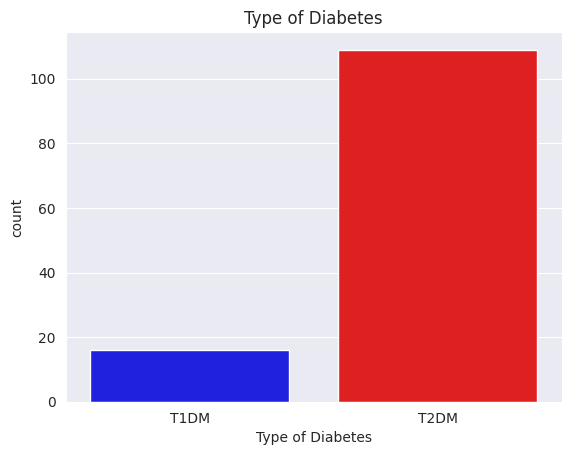

In [7]:
sns.countplot(x='Type of Diabetes', data=combined_df, hue='Type of Diabetes', palette=['blue', 'red'])
plt.title('Type of Diabetes')
plt.show()

## Histogram for types of diabetes

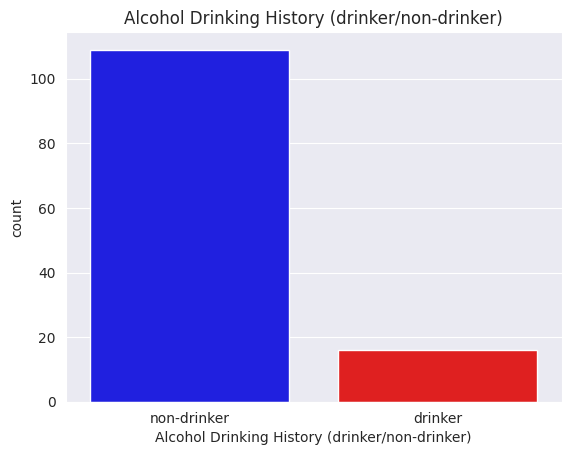

In [8]:
sns.countplot(x='Alcohol Drinking History (drinker/non-drinker)', hue='Alcohol Drinking History (drinker/non-drinker)',
              palette=['blue', 'red'], data=combined_df)
plt.title('Alcohol Drinking History (drinker/non-drinker)')
plt.show()

## Histogram for Acute Diabetic Complications

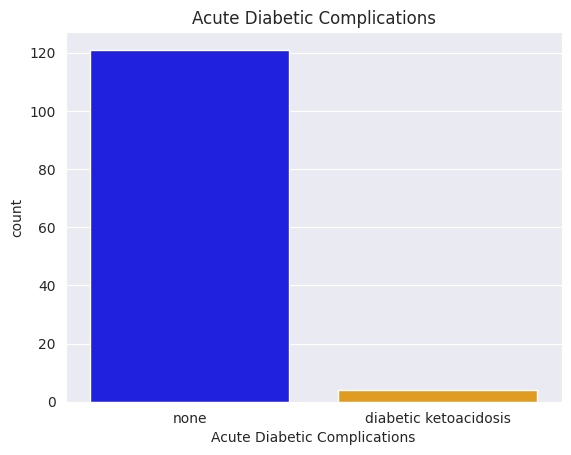

In [9]:
sns.countplot(x='Acute Diabetic Complications', hue='Acute Diabetic Complications', data=combined_df,
              palette=['blue', 'orange'])
plt.title('Acute Diabetic Complications')
plt.show()
# peripheral arterial list_of_categories, cerebrovascular list_of_categories

## Diabetic Macrovascular Complications

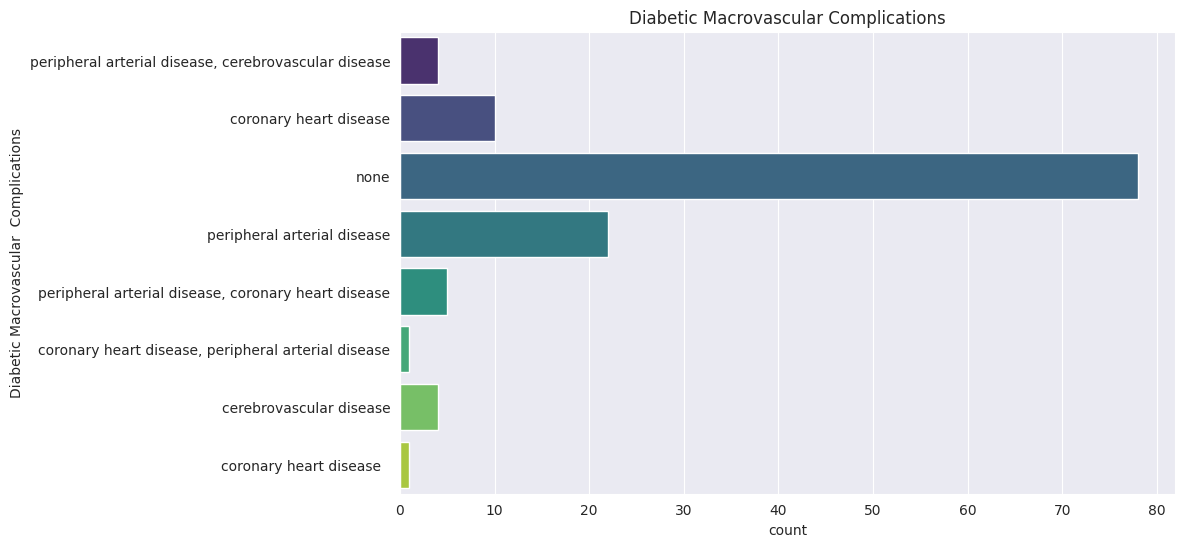

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Diabetic Macrovascular  Complications', hue='Diabetic Macrovascular  Complications', data=combined_df,
              palette='viridis')
plt.title('Diabetic Macrovascular Complications')
plt.show()

## Diabetic Microvascular Complications

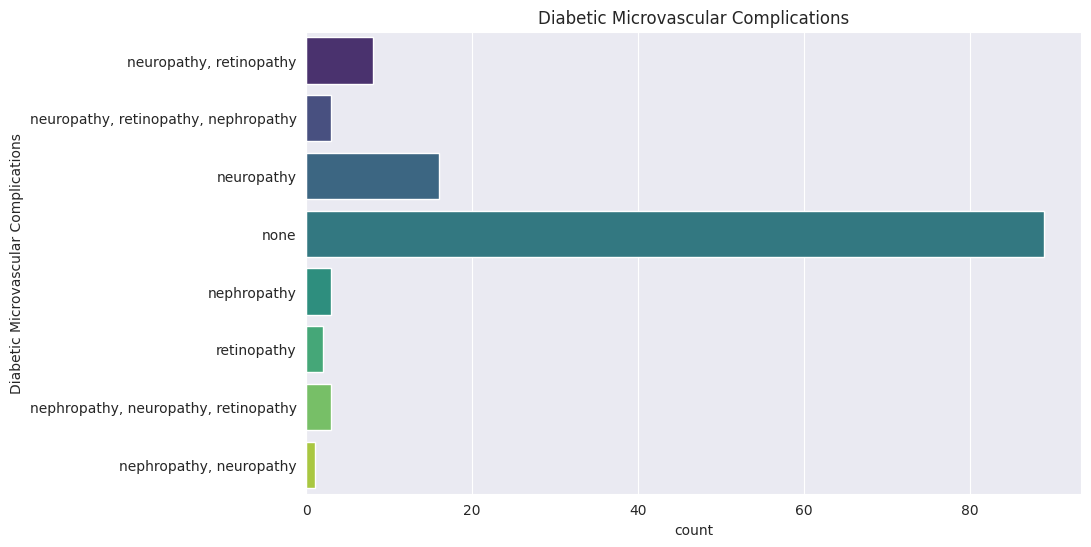

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Diabetic Microvascular Complications', hue='Diabetic Microvascular Complications', data=combined_df,
              palette='viridis')
plt.title('Diabetic Microvascular Complications')
plt.show()

In [12]:
combined_df['Diabetic Microvascular Complications'].value_counts()

Diabetic Microvascular Complications
none                                    89
neuropathy                              16
neuropathy, retinopathy                  8
neuropathy, retinopathy, nephropathy     3
nephropathy                              3
nephropathy, neuropathy, retinopathy     3
retinopathy                              2
nephropathy, neuropathy                  1
Name: count, dtype: int64

## Comorbidities

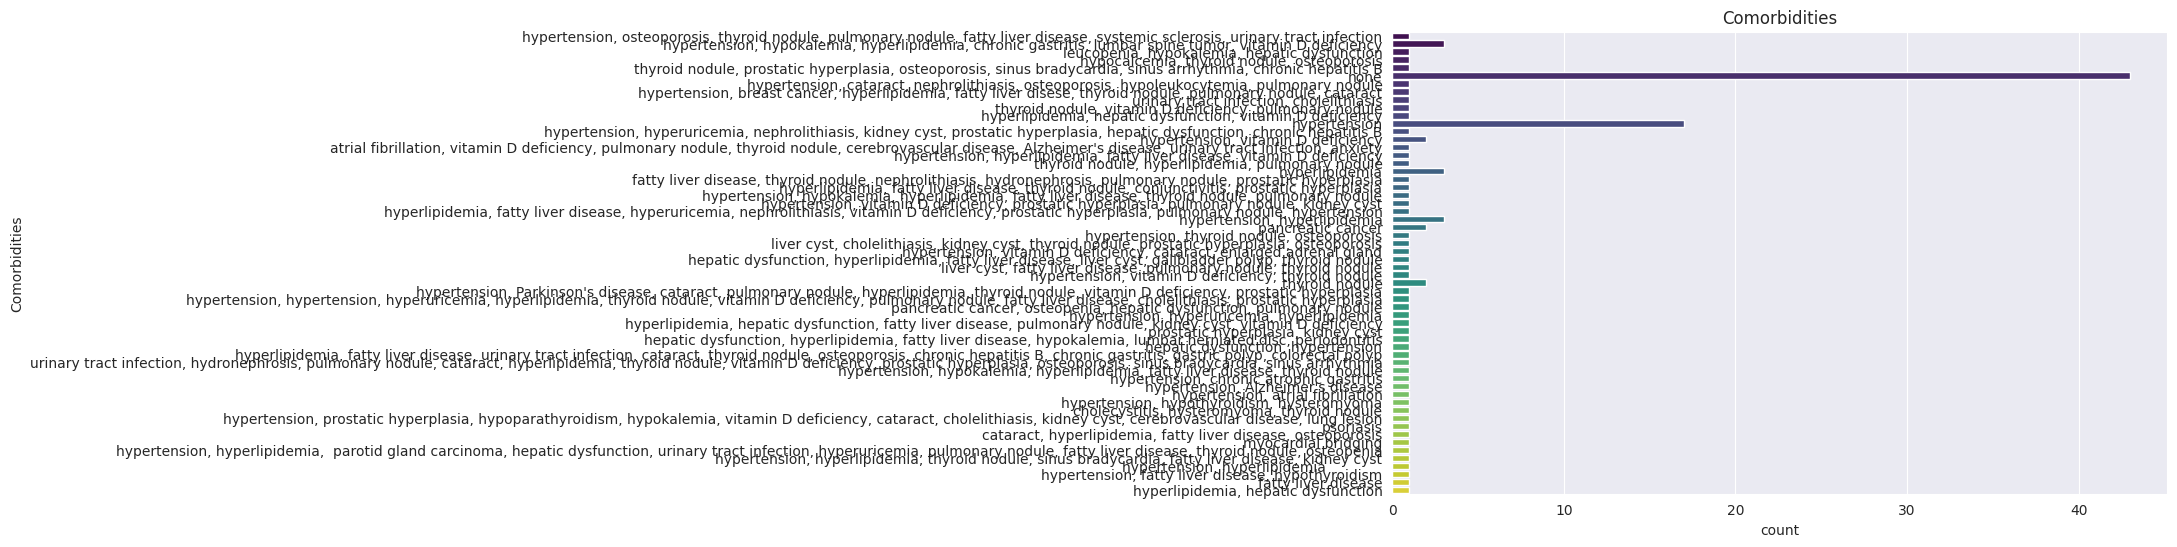

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Comorbidities', hue='Comorbidities', data=combined_df,
              palette='viridis')
plt.title('Comorbidities')
plt.show()

## Hypoglycemic Agents

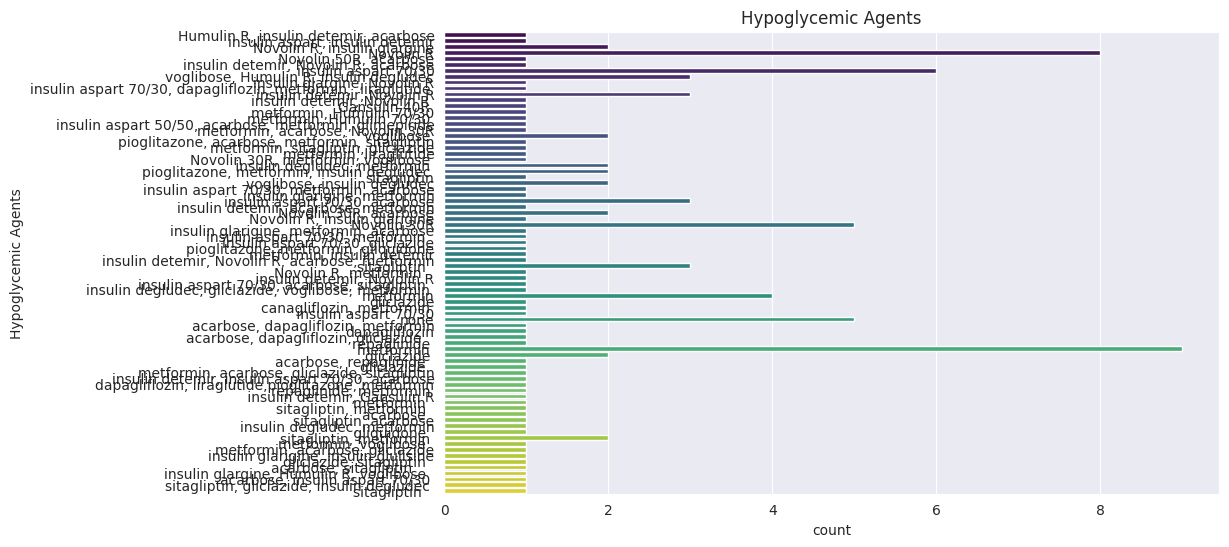

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Hypoglycemic Agents', hue='Hypoglycemic Agents', data=combined_df,
              palette='viridis')
plt.title('Hypoglycemic Agents')
plt.show()

## Other Agents

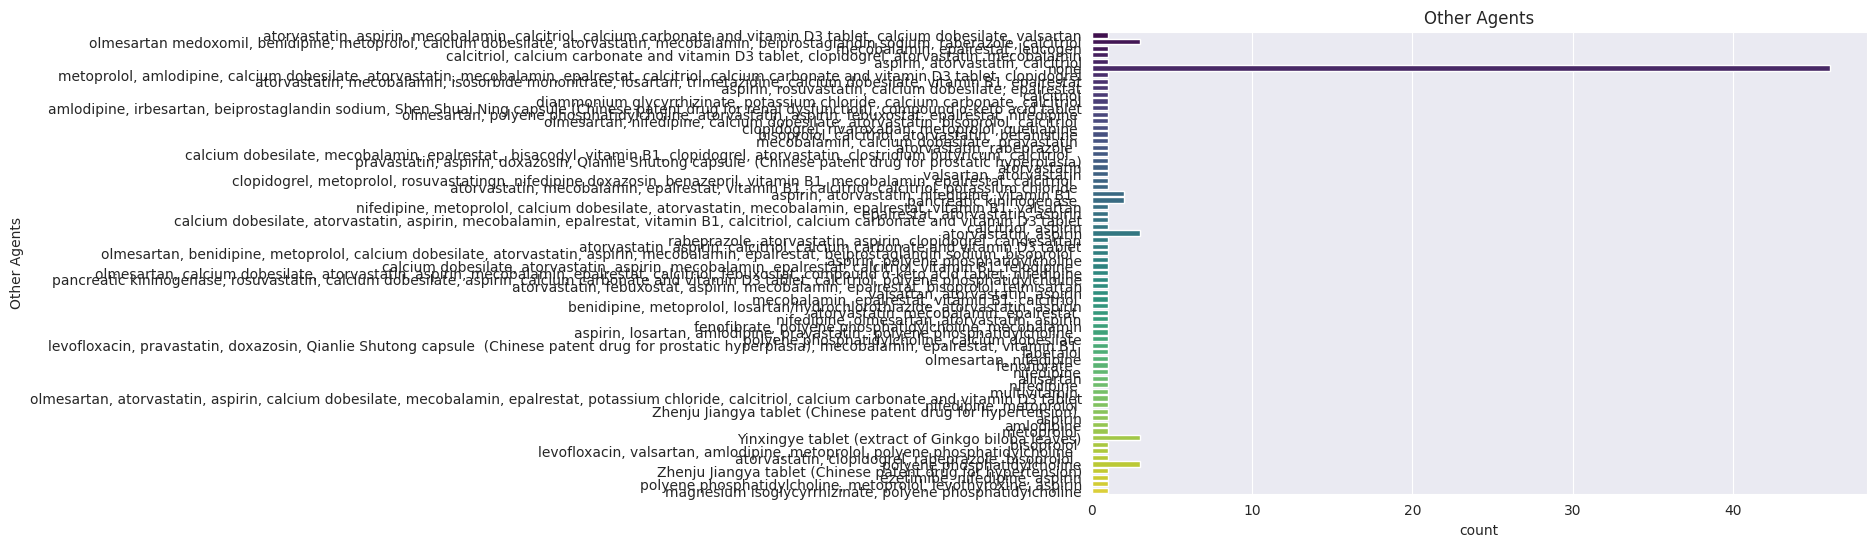

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Other Agents', hue='Other Agents', data=combined_df,
              palette='viridis')
plt.title('Other Agents')
plt.show()

## Hypoglycemia

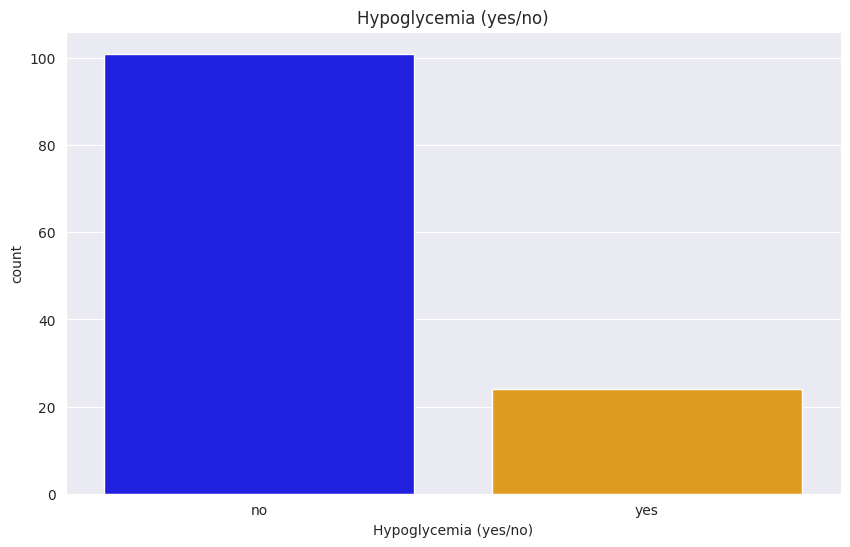

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Hypoglycemia (yes/no)', hue='Hypoglycemia (yes/no)', data=combined_df,
              palette=['blue', 'orange'])
plt.title('Hypoglycemia (yes/no)')
plt.show()

## Gender (Female=1, Male=2)

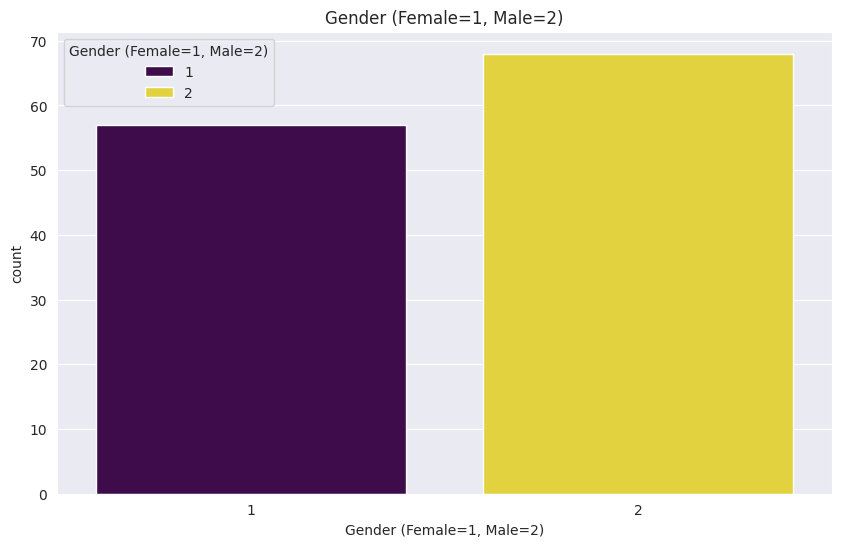

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender (Female=1, Male=2)', hue='Gender (Female=1, Male=2)', data=combined_df, palette='viridis')
plt.title('Gender (Female=1, Male=2)')
plt.show()

## number types

array([[<Axes: title={'center': 'Age (years)'}>,
        <Axes: title={'center': 'Height (m)'}>,
        <Axes: title={'center': 'Weight (kg)'}>,
        <Axes: title={'center': 'BMI (kg/m2)'}>,
        <Axes: title={'center': 'Smoking History (pack year)'}>],
       [<Axes: title={'center': 'Duration of Diabetes (years)'}>,
        <Axes: title={'center': 'Fasting Plasma Glucose (mg/dl)'}>,
        <Axes: title={'center': '2-hour Postprandial Plasma Glucose (mg/dl)'}>,
        <Axes: title={'center': 'Fasting C-peptide (nmol/L)'}>,
        <Axes: title={'center': '2-hour Postprandial C-peptide (nmol/L)'}>],
       [<Axes: title={'center': 'Fasting Insulin (pmol/L)'}>,
        <Axes: title={'center': '2-hour Postprandial Insulin (pmol/L)'}>,
        <Axes: title={'center': 'HbA1c (mmol/mol)'}>,
        <Axes: title={'center': 'Glycated Albumin (%)'}>,
        <Axes: title={'center': 'Total Cholesterol (mmol/L)'}>],
       [<Axes: title={'center': 'Triglyceride (mmol/L)'}>,
        <Axe

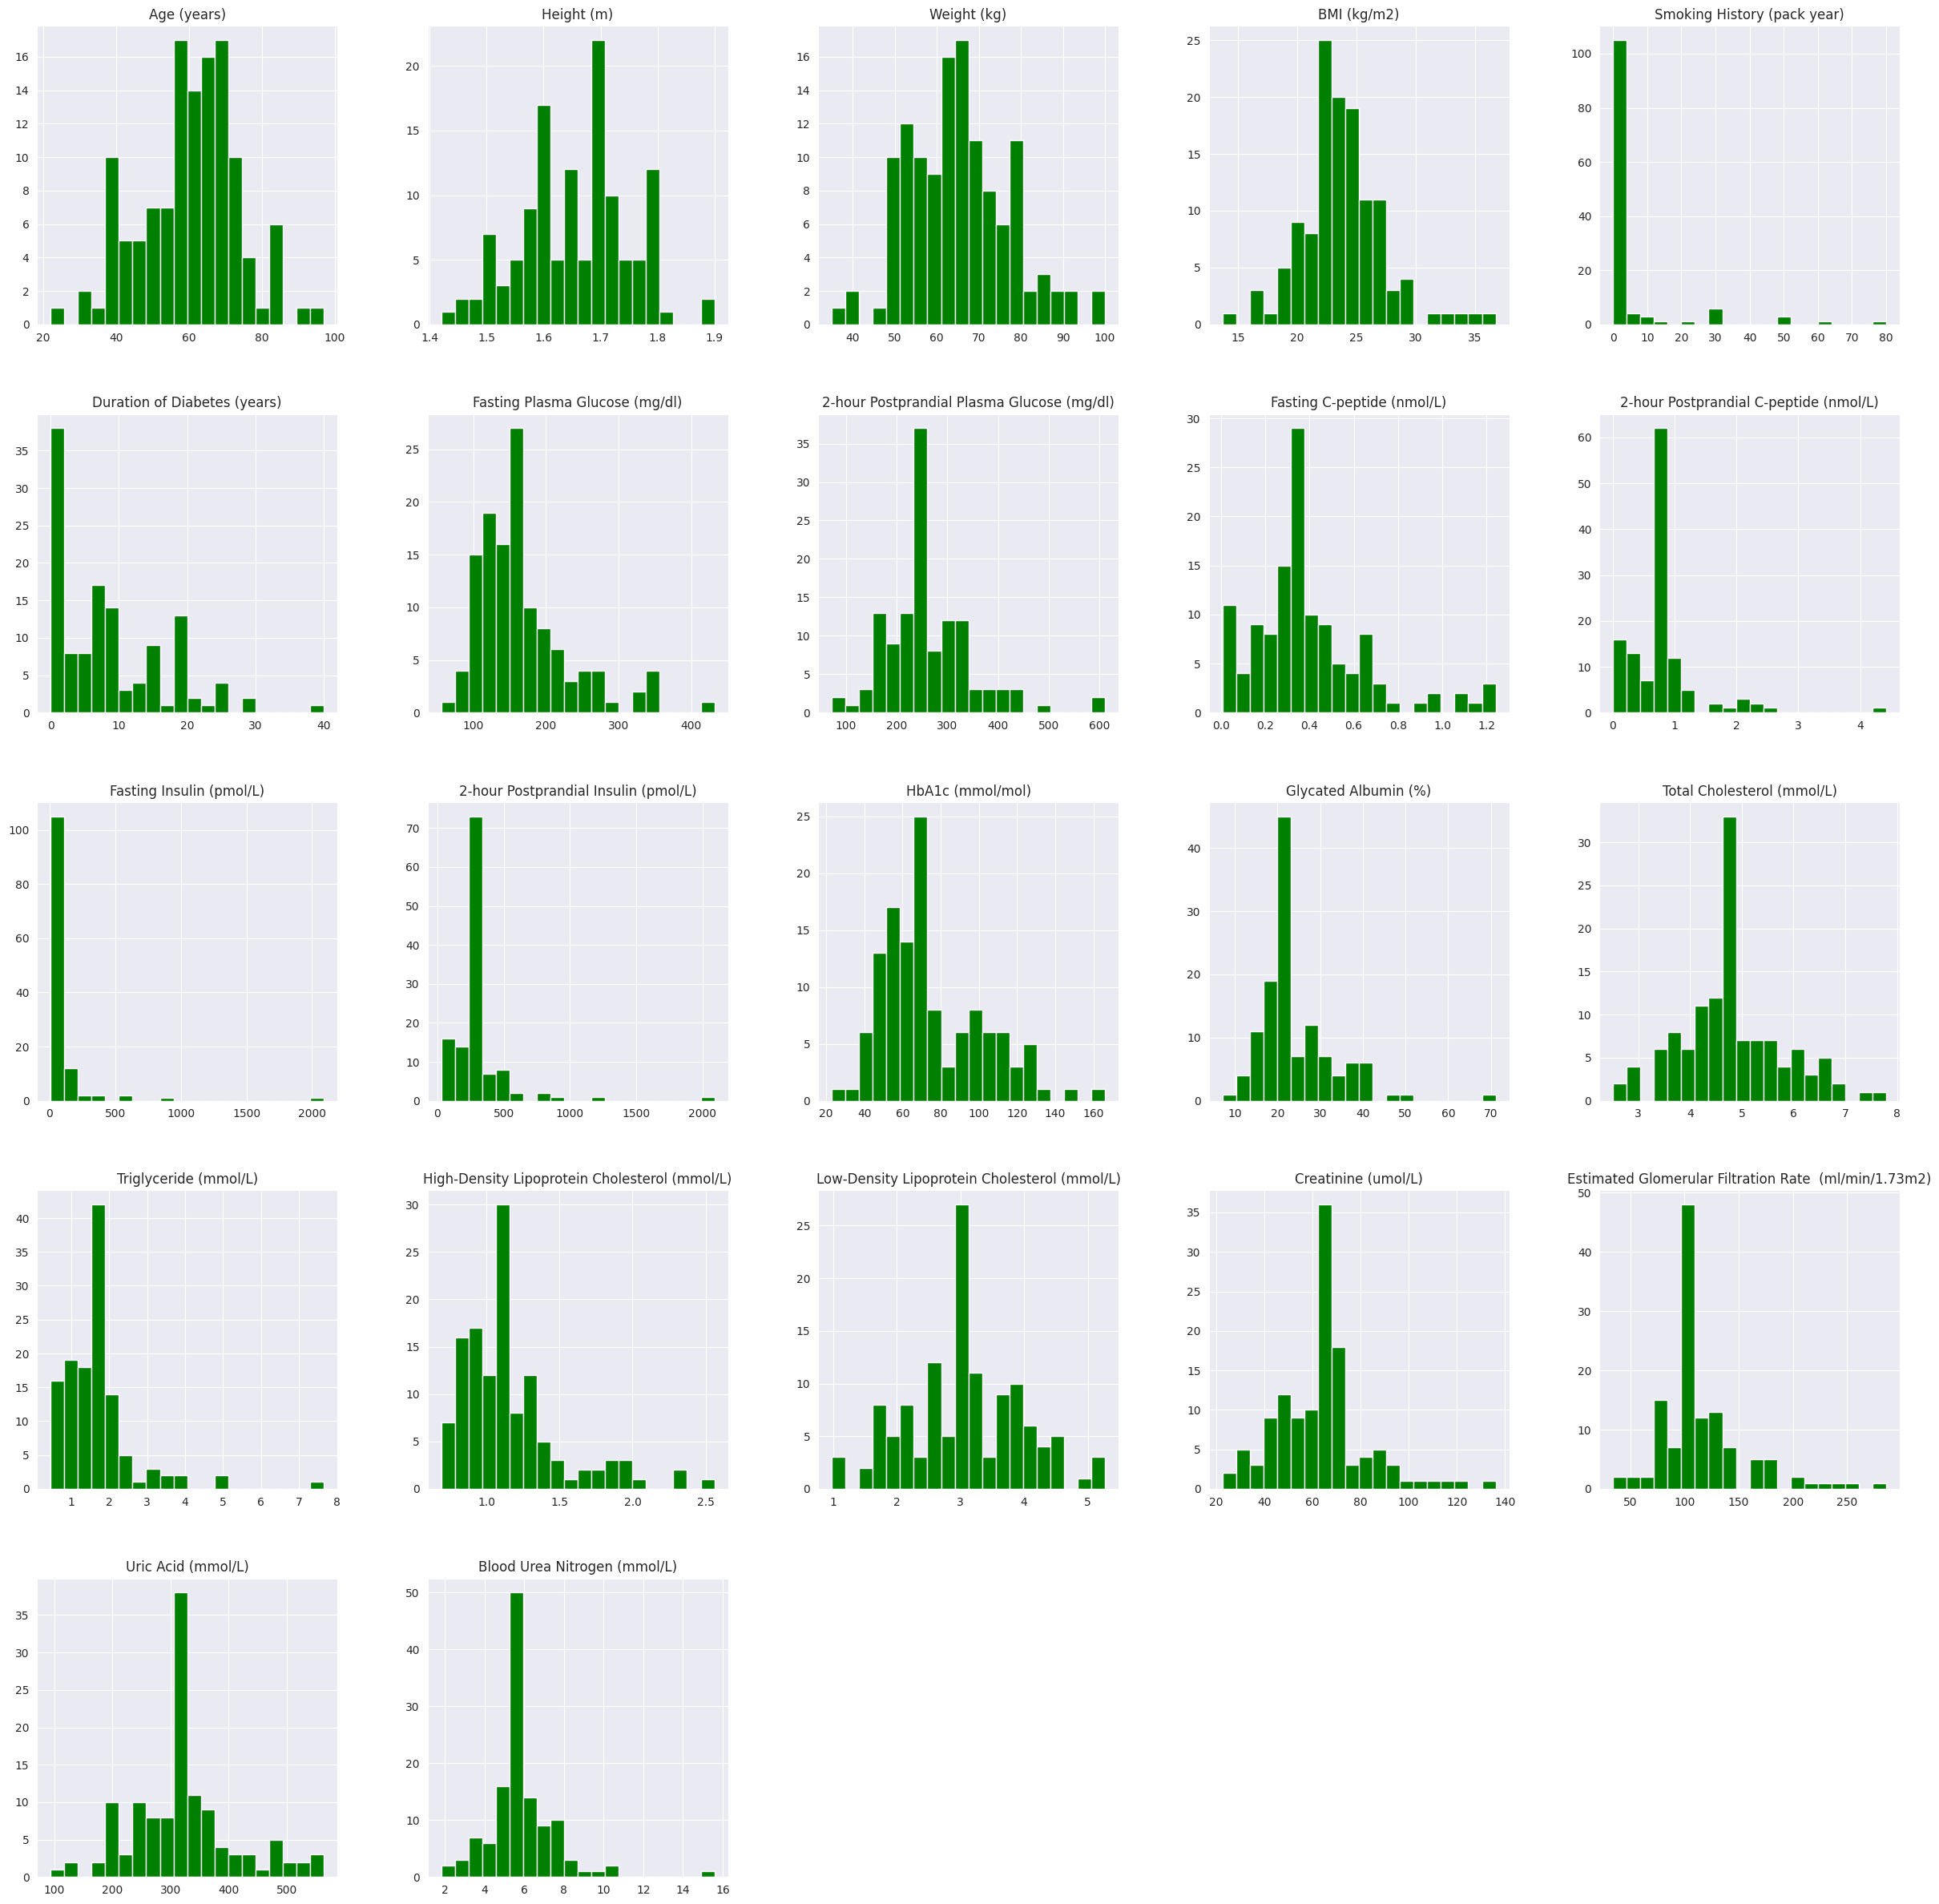

In [18]:
cols_to_fill = [
    'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
    'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
    '2-hour Postprandial Plasma Glucose (mg/dl)', 'Fasting C-peptide (nmol/L)',
    '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
    '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
    'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)',
    'High-Density Lipoprotein Cholesterol (mmol/L)', 'Low-Density Lipoprotein Cholesterol (mmol/L)',
    'Creatinine (umol/L)', 'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)',
    'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'
]
num_types_combined_df = combined_df[cols_to_fill]
num_types_combined_df.hist(bins=20, figsize=(30, 30), color='green')

# Preparing data

In [19]:
cols_to_fill = [
    'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
    'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
    '2-hour Postprandial Plasma Glucose (mg/dl)', 'Fasting C-peptide (nmol/L)',
    '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
    '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
    'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)',
    'High-Density Lipoprotein Cholesterol (mmol/L)', 'Low-Density Lipoprotein Cholesterol (mmol/L)',
    'Creatinine (umol/L)', 'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)',
    'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'
]

## emissions

In [20]:
for col in cols_to_fill:
    q1 = combined_df[col].quantile(0.25)
    q3 = combined_df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = combined_df[(combined_df[col] < lower) | (combined_df[col] > upper)]
    print(f'{col}: {len(outliers)} emissions')

Age (years): 2 emissions
Height (m): 1 emissions
Weight (kg): 2 emissions
BMI (kg/m2): 7 emissions
Smoking History (pack year): 22 emissions
Duration of Diabetes (years): 1 emissions
Fasting Plasma Glucose (mg/dl): 7 emissions
2-hour Postprandial Plasma Glucose (mg/dl): 5 emissions
Fasting C-peptide (nmol/L): 8 emissions
2-hour Postprandial C-peptide (nmol/L): 24 emissions
Fasting Insulin (pmol/L): 12 emissions
2-hour Postprandial Insulin (pmol/L): 62 emissions
HbA1c (mmol/mol): 1 emissions
Glycated Albumin (%): 5 emissions
Total Cholesterol (mmol/L): 5 emissions
Triglyceride (mmol/L): 10 emissions
High-Density Lipoprotein Cholesterol (mmol/L): 10 emissions
Low-Density Lipoprotein Cholesterol (mmol/L): 0 emissions
Creatinine (umol/L): 7 emissions
Estimated Glomerular Filtration Rate  (ml/min/1.73m2): 17 emissions
Uric Acid (mmol/L): 7 emissions
Blood Urea Nitrogen (mmol/L): 14 emissions


## check unique values

## Diabetic Macrovascular  Complications

In [21]:
unique_values = set()
for row in combined_df['Diabetic Macrovascular  Complications']:
    for item in row.split(','):
        item = item.strip().lower()
        if item and item != 'none':
            unique_values.add(item)

for value in unique_values:
    print(value)

cerebrovascular disease
peripheral arterial disease
coronary heart disease


## Diabetic Microvascular  Complications

In [22]:
unique_values = set()
for row in combined_df['Diabetic Microvascular Complications']:
    for item in row.split(','):
        item = item.strip().lower()
        if item and item != 'none':
            unique_values.add(item)

for value in unique_values:
    print(value)

retinopathy
neuropathy
nephropathy


## Other Agent

In [23]:
unique_values = set()
for row in combined_df['Other Agents']:
    for item in row.split(','):
        item = item.strip().lower()
        if item and item != 'none':
            unique_values.add(item)

for value in unique_values:
    print(value)

mecobalamin
fenofibrate
allisartan
epalrestat
nifedipine doxazosin
qianlie shutong capsule  (chinese patent drug for prostatic hyperplasia)
zhenju jiangya tablet (chinese patent drug for hypertension)
leucogen
levothyroxine
labetalol
losartan
potassium chloride
losartan/hydrochlorothiazide
benazepril
yinxingye tablet (extract of ginkgo biloba leaves)
ezetimibe
olmesartan medoxomil
isosorbide mononitrate
rosuvastatin
compound α-keto acid tablet
doxazosin
bisacodyl
levofloxacin
rabeprazole
rosuvastatinqn
atorvastatin
trimetazidine
felodipine
pancreatic kininogenase
beiprostaglandin sodium
calcium dobesilate
aspirin
raberazole
benidipine
vitamin b1
shen shuai ning capsule (chinese patent drug for renal dysfunction)
bisoprolol
rivaroxaban
calcium carbonate
quetiapine
pravastatin
clostridium butyricum
telmisartan
calcitriol
betahistine
multivitamin
polyene phosphatidylcholine
candesartan
diammonium glycyrrhizinate
valsartan
olmesartan
febuxostat
irbesartan
metoprolol
clopidogrel
amlodipine


## Comorbidities

In [24]:
unique_values = set()
for row in combined_df['Comorbidities']:
    for item in row.split(','):
        item = item.strip().lower()
        if item and item != 'none':
            unique_values.add(item)

for value in unique_values:
    print(value)

hyperuricemia
lung lesion
lumbar herniated disc
prostatic hyperplasia
pulmonary nodule
breast cancer
psoriasis
parkinson's disease
chronic atrophic gastritis
osteopenia
systemic sclerosis
fatty liver disease
kidney cyst
pancreatic cancer
chronic gastritis
hypocalcemia
atrial fibrillation
hydronephrosis
cerebrovascular disease
leucopenia
gallbladder polyp
hypoparathyroidism
anxiety
sinus bradycardia
osteoporosis
periodontitis
fatty liver disese
liver cyst
hypokalemia
vitamin d deficiency
hypoleukocytemia
hepatic dysfunction
conjunctivitis
parotid gland carcinoma
cholecystitis
urinary tract infection
hysteromyoma
hyperlipidemia
chronic hepatitis b
alzheimer's disease
sinus arrhythmia
nephrolithiasis
hypothyroidism
thyroid nodule
cataract
cholelithiasis
enlarged adrenal gland
hypertension
gastric polyp
myocardial bridging
colorectal polyp
lumbar spine tumor


## Hypoglycemic Agents

In [25]:
unique_values = set()
for row in combined_df['Hypoglycemic Agents']:
    for item in row.split(','):
        item = item.strip().lower()
        if item and item != 'none':
            unique_values.add(item)

for value in unique_values:
    print(value)

insulin glargine
insulin glarigine
humulin 70/30
insulin detemir
gliclazide
dapagliflozin
voglibose
repaglinide
pioglitazone
novolin 30r
gansulin r
glimepiride
gansulin 40r
gliquidone
novolin 50r
insulin aspart
insulin aspart 70/30
metformin
canagliflozin
insulin degludec
novolin r
acarbose
insulin aspart 50/50
sitagliptin
insulin glulisine
liraglutide
humulin r


## correction emissions

In [26]:
combined_df = combined_df[combined_df['Fasting Insulin (pmol/L)'] < 700]
combined_df = combined_df[combined_df['2-hour Postprandial Insulin (pmol/L)'] < 800]

## fix faulty values

In [27]:
combined_df['Other Agents'] = combined_df['Other Agents'].str.replace('raberazole', 'rabeprazole')
combined_df['Other Agents'] = combined_df['Other Agents'].str.replace('calcium carbonate and vitamin D3 tablet',
                                                                      'calcium carbonate, vitamin D3 tablet')
combined_df['Other Agents'] = combined_df['Other Agents'].str.replace('rosuvastatinqn', 'rosuvastatin')
combined_df['Other Agents'] = combined_df['Other Agents'].str.replace('nifedipine doxazosin', 'nifedipine, doxazosin')

## split data in some objects types (WE SKIP IT, 'CAUSE WE WILL HAVE A LOT OF COLUMNS)

### Diabetic Macrovascular  Complications /  Diabetic Microvascular Complications / Other Agent / Comorbidities/ Hypoglycemic Agents (it's not important)

In [28]:
# unique_values = set()
# for row in combined_df['Diabetic Macrovascular  Complications']:
#     for item in row.split(','):
#         item = item.strip().lower()
#         if item and item != 'none':
#             unique_values.add(item)
#
# for value in unique_values:
#     print(value)
#     column_name = value.replace(' ', '_')
#     combined_df[column_name] = combined_df['Diabetic Macrovascular  Complications'].apply(
#         lambda x: int(value in x.lower())
#     )


# grouped columns

# COMMON FUNCTIONS

## find_unknown_agents

In [29]:
def find_unknown_agents(df, col_name, items_to_group):
    all_agents = set()

    for elem in df[col_name]:
        agents = [agent.strip() for agent in elem.split(',')]
        all_agents.update(agents)

    unknown_agents = sorted(
        [unk_ag for unk_ag in all_agents if unk_ag not in items_to_group and unk_ag.lower() != 'none'])

    for unk_ag in unknown_agents: print(unk_ag)

## add_group_flags

In [30]:
def add_group_flags(df, column_name, items_to_group):
    all_groups = sorted(set(items_to_group.values()))

    def parse_agents(row):
        if pd.isna(row): return []
        return [agent.strip() for agent in row.split(',')]

    for group in all_groups:
        df[f'has_{group}'] = df[column_name].apply(
            lambda x: int(any(items_to_group.get(agent) == group for agent in parse_agents(x)))
        )

    df = df.drop(columns=[column_name], axis=1)
    return df

## Other Agents

In [31]:
drug_to_group = {
    # hypolipidemic
    'pravastatin': 'hypolipidemic',
    'rosuvastatin': 'hypolipidemic',
    'fenofibrate': 'hypolipidemic',
    'ezetimibe': 'hypolipidemic',
    'atorvastatin': 'hypolipidemic',

    # angioprotectors
    'calcium dobesilate': 'angioprotectors',
    'beiprostaglandin sodium': 'angioprotectors',

    # ace inhibitors
    'benazepril': 'ace_inhibitors',

    # minerals and vitamins
    'potassium chloride': 'minerals_and_vitamins',
    'calcium carbonate': 'minerals_and_vitamins',
    'calcitriol': 'minerals_and_vitamins',
    'multivitamin': 'minerals_and_vitamins',
    'vitamin B1': 'minerals_and_vitamins',
    'vitamin D3 tablet': 'minerals_and_vitamins',
    'mecobalamin': 'minerals_and_vitamins',

    # probiotics
    'clostridium butyricum': 'probiotics',

    # ARB
    'telmisartan': 'arb',
    'valsartan': 'arb',
    'olmesartan medoxomil': 'arb',
    'olmesartan': 'arb',
    'losartan': 'arb',
    'losartan/hydrochlorothiazide': 'arb',
    'irbesartan': 'arb',
    'candesartan': 'arb',
    'allisartan': 'arb',

    # psychotropic
    'quetiapine': 'psychotropic',

    # antianginal
    'isosorbide mononitrate': 'antianginal',

    # gout treatment
    'febuxostat': 'gout_treatment',

    # laxatives
    'bisacodyl': 'laxatives',

    # urological drugs
    'Qianlie Shutong capsule  (Chinese patent drug for prostatic hyperplasia)': 'urological_drugs',

    # calcium channel blockers
    'nifedipine': 'calcium_channel_blockers',
    'amlodipine': 'calcium_channel_blockers',
    'felodipine': 'calcium_channel_blockers',
    'benidipine': 'calcium_channel_blockers',

    # antiarrhythmic
    'doxazosin': 'antiarrhythmic',
    'labetalol': 'antiarrhythmic',
    'bisoprolol': 'antiarrhythmic',
    'metoprolol': 'antiarrhythmic',

    # gastroprotective
    'rabeprazole': 'gastroprotective',

    # circulatory support
    'Yinxingye tablet (extract of Ginkgo biloba leaves)': 'circulatory_support',

    # antithrombotic
    'aspirin': 'antithrombotic',
    'clopidogrel': 'antithrombotic',
    'rivaroxaban': 'antithrombotic',

    # vasodilators
    'trimetazidine': 'vasodilators',
    'magnesium isoglycyrrhizinate': 'vasodilators',

    # pancreatic
    'pancreatic kininogenase': 'pancreatic',

    # neuroprotectors
    'epalrestat': 'neuroprotectors',

    # kidney support
    'compound α-keto acid tablet': 'kidney_support',
    'Shen Shuai Ning capsule (Chinese patent drug for renal dysfunction)': 'kidney_support',

    # hepatoprotector
    'polyene phosphatidylcholine': 'hepatoprotector',
    'diammonium glycyrrhizinate': 'hepatoprotector',

    # immunomodulators
    'leucogen': 'immunomodulators',

    # thyroid diseases
    'levothyroxine': 'thyroid_diseases',

    # antibiotics
    'levofloxacin': 'antibiotics',

    # antihypertensives
    'Zhenju Jiangya tablet (Chinese patent drug for hypertension)': 'antihypertensives',

    # vestibular disorders
    'betahistine': 'vestibular_disorders',
}

In [32]:
find_unknown_agents(combined_df, 'Other Agents', drug_to_group)

In [33]:
combined_df = add_group_flags(combined_df, 'Other Agents', drug_to_group)

In [34]:
combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_laxatives,has_minerals_and_vitamins,has_neuroprotectors,has_pancreatic,has_probiotics,has_psychotropic,has_thyroid_diseases,has_urological_drugs,has_vasodilators,has_vestibular_disorders
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,non-drinker,T1DM,10.00,...,0,1,0,0,0,0,0,0,0,0
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,drinker,T1DM,26.00,...,0,1,0,0,0,0,0,0,0,0
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,drinker,T1DM,26.00,...,0,1,0,0,0,0,0,0,0,0
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,drinker,T1DM,26.00,...,0,1,0,0,0,0,0,0,0,0
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,non-drinker,T1DM,0.08,...,0,1,1,0,0,0,0,0,0,0


## a narrower list of drug groups

In [35]:
narrower_list_of_drug_groups = {
    ## cardiovascular_drugs
    'pravastatin': 'cardiovascular_drugs',
    'rosuvastatin': 'cardiovascular_drugs',
    'fenofibrate': 'cardiovascular_drugs',
    'ezetimibe': 'cardiovascular_drugs',
    'atorvastatin': 'cardiovascular_drugs',
    'benazepril': 'cardiovascular_drugs',
    'telmisartan': 'cardiovascular_drugs',
    'valsartan': 'cardiovascular_drugs',
    'olmesartan medoxomil': 'cardiovascular_drugs',
    'olmesartan': 'cardiovascular_drugs',
    'losartan': 'cardiovascular_drugs',
    'losartan/hydrochlorothiazide': 'cardiovascular_drugs',
    'irbesartan': 'cardiovascular_drugs',
    'candesartan': 'cardiovascular_drugs',
    'allisartan': 'cardiovascular_drugs',
    'nifedipine': 'cardiovascular_drugs',
    'amlodipine': 'cardiovascular_drugs',
    'felodipine': 'cardiovascular_drugs',
    'benidipine': 'cardiovascular_drugs',
    'doxazosin': 'cardiovascular_drugs',
    'labetalol': 'cardiovascular_drugs',
    'bisoprolol': 'cardiovascular_drugs',
    'metoprolol': 'cardiovascular_drugs',
    'aspirin': 'cardiovascular_drugs',
    'clopidogrel': 'cardiovascular_drugs',
    'rivaroxaban': 'cardiovascular_drugs',
    'trimetazidine': 'cardiovascular_drugs',
    'magnesium isoglycyrrhizinate': 'cardiovascular_drugs',
    'Zhenju Jiangya tablet (Chinese patent drug for hypertension)': 'cardiovascular_drugs',

    ## minerals_and_vitamins
    'potassium chloride': 'minerals_and_vitamins',
    'calcium carbonate': 'minerals_and_vitamins',
    'calcitriol': 'minerals_and_vitamins',
    'multivitamin': 'minerals_and_vitamins',
    'vitamin B1': 'minerals_and_vitamins',
    'vitamin D3 tablet': 'minerals_and_vitamins',
    'mecobalamin': 'minerals_and_vitamins',

    ## kidney_drugs
    'Qianlie Shutong capsule  (Chinese patent drug for prostatic hyperplasia)': 'kidney_drugs',
    'Shen Shuai Ning capsule (Chinese patent drug for renal dysfunction)': 'kidney_drugs',
    'compound α-keto acid tablet': 'kidney_drugs',

    ## neurological_and_psych_drugs
    'betahistine': 'neurological_and_psych_drugs',
    'epalrestat': 'neurological_and_psych_drugs',
    'quetiapine': 'neurological_and_psych_drugs',

    ## gastrointestinal_drugs
    'polyene phosphatidylcholine': 'gastrointestinal_drugs',
    'diammonium glycyrrhizinate': 'gastrointestinal_drugs',
    'pancreatic kininogenase': 'gastrointestinal_drugs',
    'rabeprazole': 'gastrointestinal_drugs',
    'clostridium butyricum': 'gastrointestinal_drugs',
    'bisacodyl': 'gastrointestinal_drugs',
    # todo. use if model is overfitting. add last groups
}

## Comorbidities

In [36]:
disease_to_group = {
    # diseases_of_the_stomach_and_intestines
    'chronic atrophic gastritis': 'diseases_of_the_stomach_and_intestines',
    'colorectal polyp': 'diseases_of_the_stomach_and_intestines',
    'chronic gastritis': 'diseases_of_the_stomach_and_intestines',
    'gastric polyp': 'diseases_of_the_stomach_and_intestines',

    # diseases_of_the_musculoskeletal_system
    'lumbar herniated disc': 'diseases_of_the_musculoskeletal_system',
    'osteopenia': 'diseases_of_the_musculoskeletal_system',
    'osteoporosis': 'diseases_of_the_musculoskeletal_system',
    'lumbar spine tumor': 'diseases_of_the_musculoskeletal_system',

    # cardiovascular_diseases
    'myocardial bridging': 'cardiovascular_diseases',
    'sinus arrhythmia': 'cardiovascular_diseases',
    'hypertension': 'cardiovascular_diseases',
    'hyperlipidemia': 'cardiovascular_diseases',
    'sinus bradycardia': 'cardiovascular_diseases',
    'atrial fibrillation': 'cardiovascular_diseases',

    # kidney_diseases
    'kidney cyst': 'kidney_diseases',
    'hydronephrosis': 'kidney_diseases',
    'nephrolithiasis': 'kidney_diseases',
    'urinary tract infection': 'kidney_diseases',

    # dental_diseases
    'periodontitis': 'dental_diseases',

    # gynecological_diseases
    'hysteromyoma': 'gynecological_diseases',

    # neurological_and_psychiatric_diseases
    'anxiety': 'neurological_and_psychiatric_diseases',
    'cerebrovascular disease': 'neurological_and_psychiatric_diseases',
    "Alzheimer's disease": 'neurological_and_psychiatric_diseases',
    "Parkinson's disease": 'neurological_and_psychiatric_diseases',

    # liver_diseases
    'fatty liver disease': 'liver_diseases',
    'fatty liver disese': 'liver_diseases',
    'liver cyst': 'liver_diseases',
    'hepatic dysfunction': 'liver_diseases',

    # gallbladder_diseases
    'cholecystitis': 'gallbladder_diseases',
    'cholelithiasis': 'gallbladder_diseases',
    'gallbladder polyp': 'gallbladder_diseases',

    # infectious_diseases
    'chronic hepatitis B': 'infectious_diseases',

    # oncology
    'breast cancer': 'oncology',
    'pancreatic cancer': 'oncology',
    'parotid gland carcinoma': 'oncology',
    'lung lesion': 'oncology',
    'pulmonary nodule': 'oncology',

    # endocrine_diseases
    'hypoparathyroidism': 'endocrine_diseases',
    'hypothyroidism': 'endocrine_diseases',
    'enlarged adrenal gland': 'endocrine_diseases',
    'thyroid nodule': 'endocrine_diseases',

    # male_reproductive_diseases
    'prostatic hyperplasia': 'male_reproductive_diseases',

    # eye_diseases
    'cataract': 'eye_diseases',
    'conjunctivitis': 'eye_diseases',

    # hematologic_disorders
    'hypoleukocytemia': 'hematologic_disorders',
    'leucopenia': 'hematologic_disorders',

    # autoimmune_diseases
    'systemic sclerosis': 'autoimmune_diseases',
    'psoriasis': 'autoimmune_diseases',

    # electrolyte_and_mineral_disorders
    'hypocalcemia': 'electrolyte_and_mineral_disorders',
    'hypokalemia': 'electrolyte_and_mineral_disorders',
    'vitamin D deficiency': 'electrolyte_and_mineral_disorders',
    'hyperuricemia': 'electrolyte_and_mineral_disorders',
}

In [37]:
find_unknown_agents(combined_df, 'Comorbidities', disease_to_group)

In [38]:
combined_df = add_group_flags(combined_df, 'Comorbidities', disease_to_group)

In [39]:
combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_eye_diseases,has_gallbladder_diseases,has_gynecological_diseases,has_hematologic_disorders,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,non-drinker,T1DM,10.00,...,0,0,0,0,0,1,1,0,0,1
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,0
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,0
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,0
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,non-drinker,T1DM,0.08,...,0,0,0,1,0,0,1,0,0,0


In [40]:
combined_df.shape

(122, 74)

## check all zeros in every column starts with 'has_'

In [41]:
def check_all_zeros(df):
    for column in df.columns.tolist():
        if column.startswith('has_'):
            if all(value == 0 for value in df[column].values):
                print(df[column].name)


check_all_zeros(combined_df)

## drop unused columns

In [42]:
# split_df = combined_df.drop(columns=['Other Agents', 'Diabetic Macrovascular  Complications',
#                                      'Diabetic Microvascular Complications', 'Comorbidities'])
combined_df = combined_df.drop(columns=[
    'Hypoglycemic Agents'])  # delete this column, because we predict type of diabetes. Hypoglycemic Agents contains of type of drugs/insulin

In [43]:
combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_eye_diseases,has_gallbladder_diseases,has_gynecological_diseases,has_hematologic_disorders,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,non-drinker,T1DM,10.00,...,0,0,0,0,0,1,1,0,0,1
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,0
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,0
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,0
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,non-drinker,T1DM,0.08,...,0,0,0,1,0,0,1,0,0,0


# specify has_macrovascular and has_microvascular complications

In [44]:
def specify_has_or_no(df, column_name):
    column_name = column_name.strip()

    def has_any_value(row):
        if pd.isna(row): return 0
        for el in row.split(','):
            el = el.strip().lower()
            if el and el != 'none':
                return 1
        return 0

    new_name_column = f'has_{column_name.lower().replace(' ', '_')}'
    df[new_name_column] = df[column_name].apply(has_any_value)

    return df

In [45]:
combined_df = specify_has_or_no(combined_df, 'Diabetic Microvascular Complications')

combined_df = combined_df.drop(columns=['Diabetic Microvascular Complications'])

combined_df

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_gallbladder_diseases,has_gynecological_diseases,has_hematologic_disorders,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology,has_diabetic_microvascular_complications
0,1001_0_20210730,1,66,1.50,60,26.67,0.0,non-drinker,T1DM,10.00,...,0,0,0,0,1,1,0,0,1,1
1,1002_0_20210504,2,68,1.70,63,21.80,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,1
2,1002_1_20210521,2,68,1.70,67,23.18,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,1
3,1002_2_20210909,2,68,1.70,65,22.49,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,1
4,1003_0_20210831,2,37,1.90,60,16.62,0.0,non-drinker,T1DM,0.08,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2095_0_20201116,2,66,1.72,62,20.96,0.0,non-drinker,T2DM,7.00,...,0,0,0,0,0,0,0,0,0,0
121,2096_0_20201116,1,60,1.57,65,26.37,0.0,non-drinker,T2DM,0.10,...,0,0,0,0,0,1,0,0,0,0
122,2097_0_20201116,1,71,1.70,67,23.11,0.0,non-drinker,T2DM,20.00,...,0,0,0,0,0,0,0,0,0,0
123,2098_0_20201106,1,64,1.60,67,26.17,0.0,non-drinker,T2DM,0.10,...,0,0,0,0,0,1,0,0,0,0


In [46]:
combined_df = specify_has_or_no(combined_df, 'Diabetic Macrovascular  Complications')

combined_df = combined_df.drop(columns=['Diabetic Macrovascular  Complications'])

combined_df.head(6)

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_gynecological_diseases,has_hematologic_disorders,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology,has_diabetic_microvascular_complications,has_diabetic_macrovascular__complications
0,1001_0_20210730,1,66,1.50,60,26.67,0.0,non-drinker,T1DM,10.00,...,0,0,0,1,1,0,0,1,1,1
1,1002_0_20210504,2,68,1.70,63,21.80,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,1,1
2,1002_1_20210521,2,68,1.70,67,23.18,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,1,1
3,1002_2_20210909,2,68,1.70,65,22.49,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,1,1
4,1003_0_20210831,2,37,1.90,60,16.62,0.0,non-drinker,T1DM,0.08,...,0,1,0,0,1,0,0,0,1,0
5,1004_0_20210425,1,67,1.55,47,19.56,0.0,non-drinker,T1DM,12.00,...,0,0,0,0,0,0,0,0,1,1


In [47]:
combined_df = specify_has_or_no(combined_df, 'Acute Diabetic Complications')

combined_df = combined_df.drop(columns=['Acute Diabetic Complications'])

combined_df.head(8)

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_hematologic_disorders,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology,has_diabetic_microvascular_complications,has_diabetic_macrovascular__complications,has_acute_diabetic_complications
0,1001_0_20210730,1,66,1.50,60,26.67,0.0,non-drinker,T1DM,10.00,...,0,0,1,1,0,0,1,1,1,0
1,1002_0_20210504,2,68,1.70,63,21.80,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,1,1,1
2,1002_1_20210521,2,68,1.70,67,23.18,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,1,1,1
3,1002_2_20210909,2,68,1.70,65,22.49,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,1,1,0
4,1003_0_20210831,2,37,1.90,60,16.62,0.0,non-drinker,T1DM,0.08,...,1,0,0,1,0,0,0,1,0,1
5,1004_0_20210425,1,67,1.55,47,19.56,0.0,non-drinker,T1DM,12.00,...,0,0,0,0,0,0,0,1,1,0
6,1005_0_20210522,2,58,1.70,50,17.30,22.5,non-drinker,T1DM,16.00,...,0,1,0,0,1,0,0,0,0,0
7,1006_0_20210114,2,57,1.61,53,20.52,0.0,non-drinker,T1DM,7.00,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# label_encoder = preprocessing.LabelEncoder()
# object_columns = demos_df.select_dtypes(include=['object']).drop(columns=['Satisfaction']).columns
# for column in object_columns:
#     demos_df[column] = label_encoder.fit_transform(demos_df[column])
# demos_df.head(5)

## encoding columns Alcohol Drinking History (drinker/non-drinker) and Hypoglycemia (yes/no)

Hypoglycemia (yes/no) -> (yes 1 / no 0)
Alcohol Drinking History (drinker/non-drinker) -> (yes 0 / no 1)

In [50]:
label_encoder = preprocessing.LabelEncoder()

for col_to_encode in ['Alcohol Drinking History (drinker/non-drinker)', 'Hypoglycemia (yes/no)']:
    combined_df[col_to_encode] = label_encoder.fit_transform(combined_df[col_to_encode])

combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_hematologic_disorders,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology,has_diabetic_microvascular_complications,has_diabetic_macrovascular__complications,has_acute_diabetic_complications
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,1,T1DM,10.00,...,0,0,1,1,0,0,1,1,1,0
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,0,T1DM,26.00,...,0,0,0,0,0,0,0,1,1,1
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,0,T1DM,26.00,...,0,0,0,0,0,0,0,1,1,1
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,0,T1DM,26.00,...,0,0,0,0,0,0,0,1,1,0
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,1,T1DM,0.08,...,1,0,0,1,0,0,0,1,0,1


## rename Hypoglycemia (yes/no)

In [51]:
combined_df[f'has_hypoglycemia'] = combined_df['Hypoglycemia (yes/no)']

In [52]:
df = combined_df.drop(columns=['Hypoglycemia (yes/no)'])
df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology,has_diabetic_microvascular_complications,has_diabetic_macrovascular__complications,has_acute_diabetic_complications,has_hypoglycemia
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,1,T1DM,10.00,...,0,1,1,0,0,1,1,1,0,0
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,0,T1DM,26.00,...,0,0,0,0,0,0,1,1,1,1
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,0,T1DM,26.00,...,0,0,0,0,0,0,1,1,1,1
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,0,T1DM,26.00,...,0,0,0,0,0,0,1,1,0,1
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,1,T1DM,0.08,...,0,0,1,0,0,0,1,0,1,1


In [53]:
df.columns
# Gender, 'Type of Diabetes','has_ace_inhibitors', 'has_angioprotectors', 'has_antianginal','has_antiarrhythmic', 'has_antibiotics', 'has_antihypertensives','has_antithrombotic', 'has_arb', 'has_calcium_channel_blockers','has_circulatory_support', 'has_gastroprotective', 'has_gout_treatment','has_hepatoprotector', 'has_hypolipidemic', 'has_immunomodulators','has_kidney_support', 'has_laxatives', 'has_minerals_and_vitamins','has_neuroprotectors', 'has_pancreatic', 'has_probiotics','has_psychotropic', 'has_thyroid_diseases', 'has_urological_drugs','has_vasodilators', 'has_vestibular_disorders','has_autoimmune_diseases', 'has_cardiovascular_diseases','has_dental_diseases', 'has_diseases_of_the_musculoskeletal_system','has_diseases_of_the_stomach_and_intestines','has_electrolyte_and_mineral_disorders', 'has_endocrine_diseases','has_eye_diseases', 'has_gallbladder_diseases','has_gynecological_diseases', 'has_hematologic_disorders','has_infectious_diseases', 'has_kidney_diseases', 'has_liver_diseases','has_male_reproductive_diseases','has_neurological_and_psychiatric_diseases', 'has_oncology','has_diabetic_microvascular_complications','has_diabetic_macrovascular__complications','has_acute_diabetic_complications', 'has_hypoglycemia', Alcohol Drinking History (drinker/non-drinker)


# 'Age (years)','Height (m)', 'Weight (kg)', 'BMI (kg/m2)','Smoking History (pack year)', 'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)', '2-hour Postprandial Plasma Glucose (mg/dl)', 'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)', '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)', 'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)', 'High-Density Lipoprotein Cholesterol (mmol/L)', 'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)', 'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)', 'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'

Index(['Patient Number', 'Gender (Female=1, Male=2)', 'Age (years)',
       'Height (m)', 'Weight (kg)', 'BMI (kg/m2)',
       'Smoking History (pack year)',
       'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes',
       'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
       '2-hour Postprandial Plasma Glucose (mg/dl)',
       'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)',
       'Fasting Insulin (pmol/L)', '2-hour Postprandial Insulin (pmol/L)',
       'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
       'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)',
       'High-Density Lipoprotein Cholesterol (mmol/L)',
       'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
       'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)',
       'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)',
       'has_ace_inhibitors', 'has_angioprotectors', 'has_antianginal',
       'has_antiarrhythmic', 'has_antibiot

# Visualisation with new data

## Visualisation int values

array([[<Axes: title={'center': 'Age (years)'}>,
        <Axes: title={'center': 'Height (m)'}>,
        <Axes: title={'center': 'Weight (kg)'}>,
        <Axes: title={'center': 'BMI (kg/m2)'}>,
        <Axes: title={'center': 'Smoking History (pack year)'}>],
       [<Axes: title={'center': 'Duration of Diabetes (years)'}>,
        <Axes: title={'center': 'Fasting Plasma Glucose (mg/dl)'}>,
        <Axes: title={'center': '2-hour Postprandial Plasma Glucose (mg/dl)'}>,
        <Axes: title={'center': 'Fasting C-peptide (nmol/L)'}>,
        <Axes: title={'center': '2-hour Postprandial C-peptide (nmol/L)'}>],
       [<Axes: title={'center': 'Fasting Insulin (pmol/L)'}>,
        <Axes: title={'center': '2-hour Postprandial Insulin (pmol/L)'}>,
        <Axes: title={'center': 'HbA1c (mmol/mol)'}>,
        <Axes: title={'center': 'Glycated Albumin (%)'}>,
        <Axes: title={'center': 'Total Cholesterol (mmol/L)'}>],
       [<Axes: title={'center': 'Triglyceride (mmol/L)'}>,
        <Axe

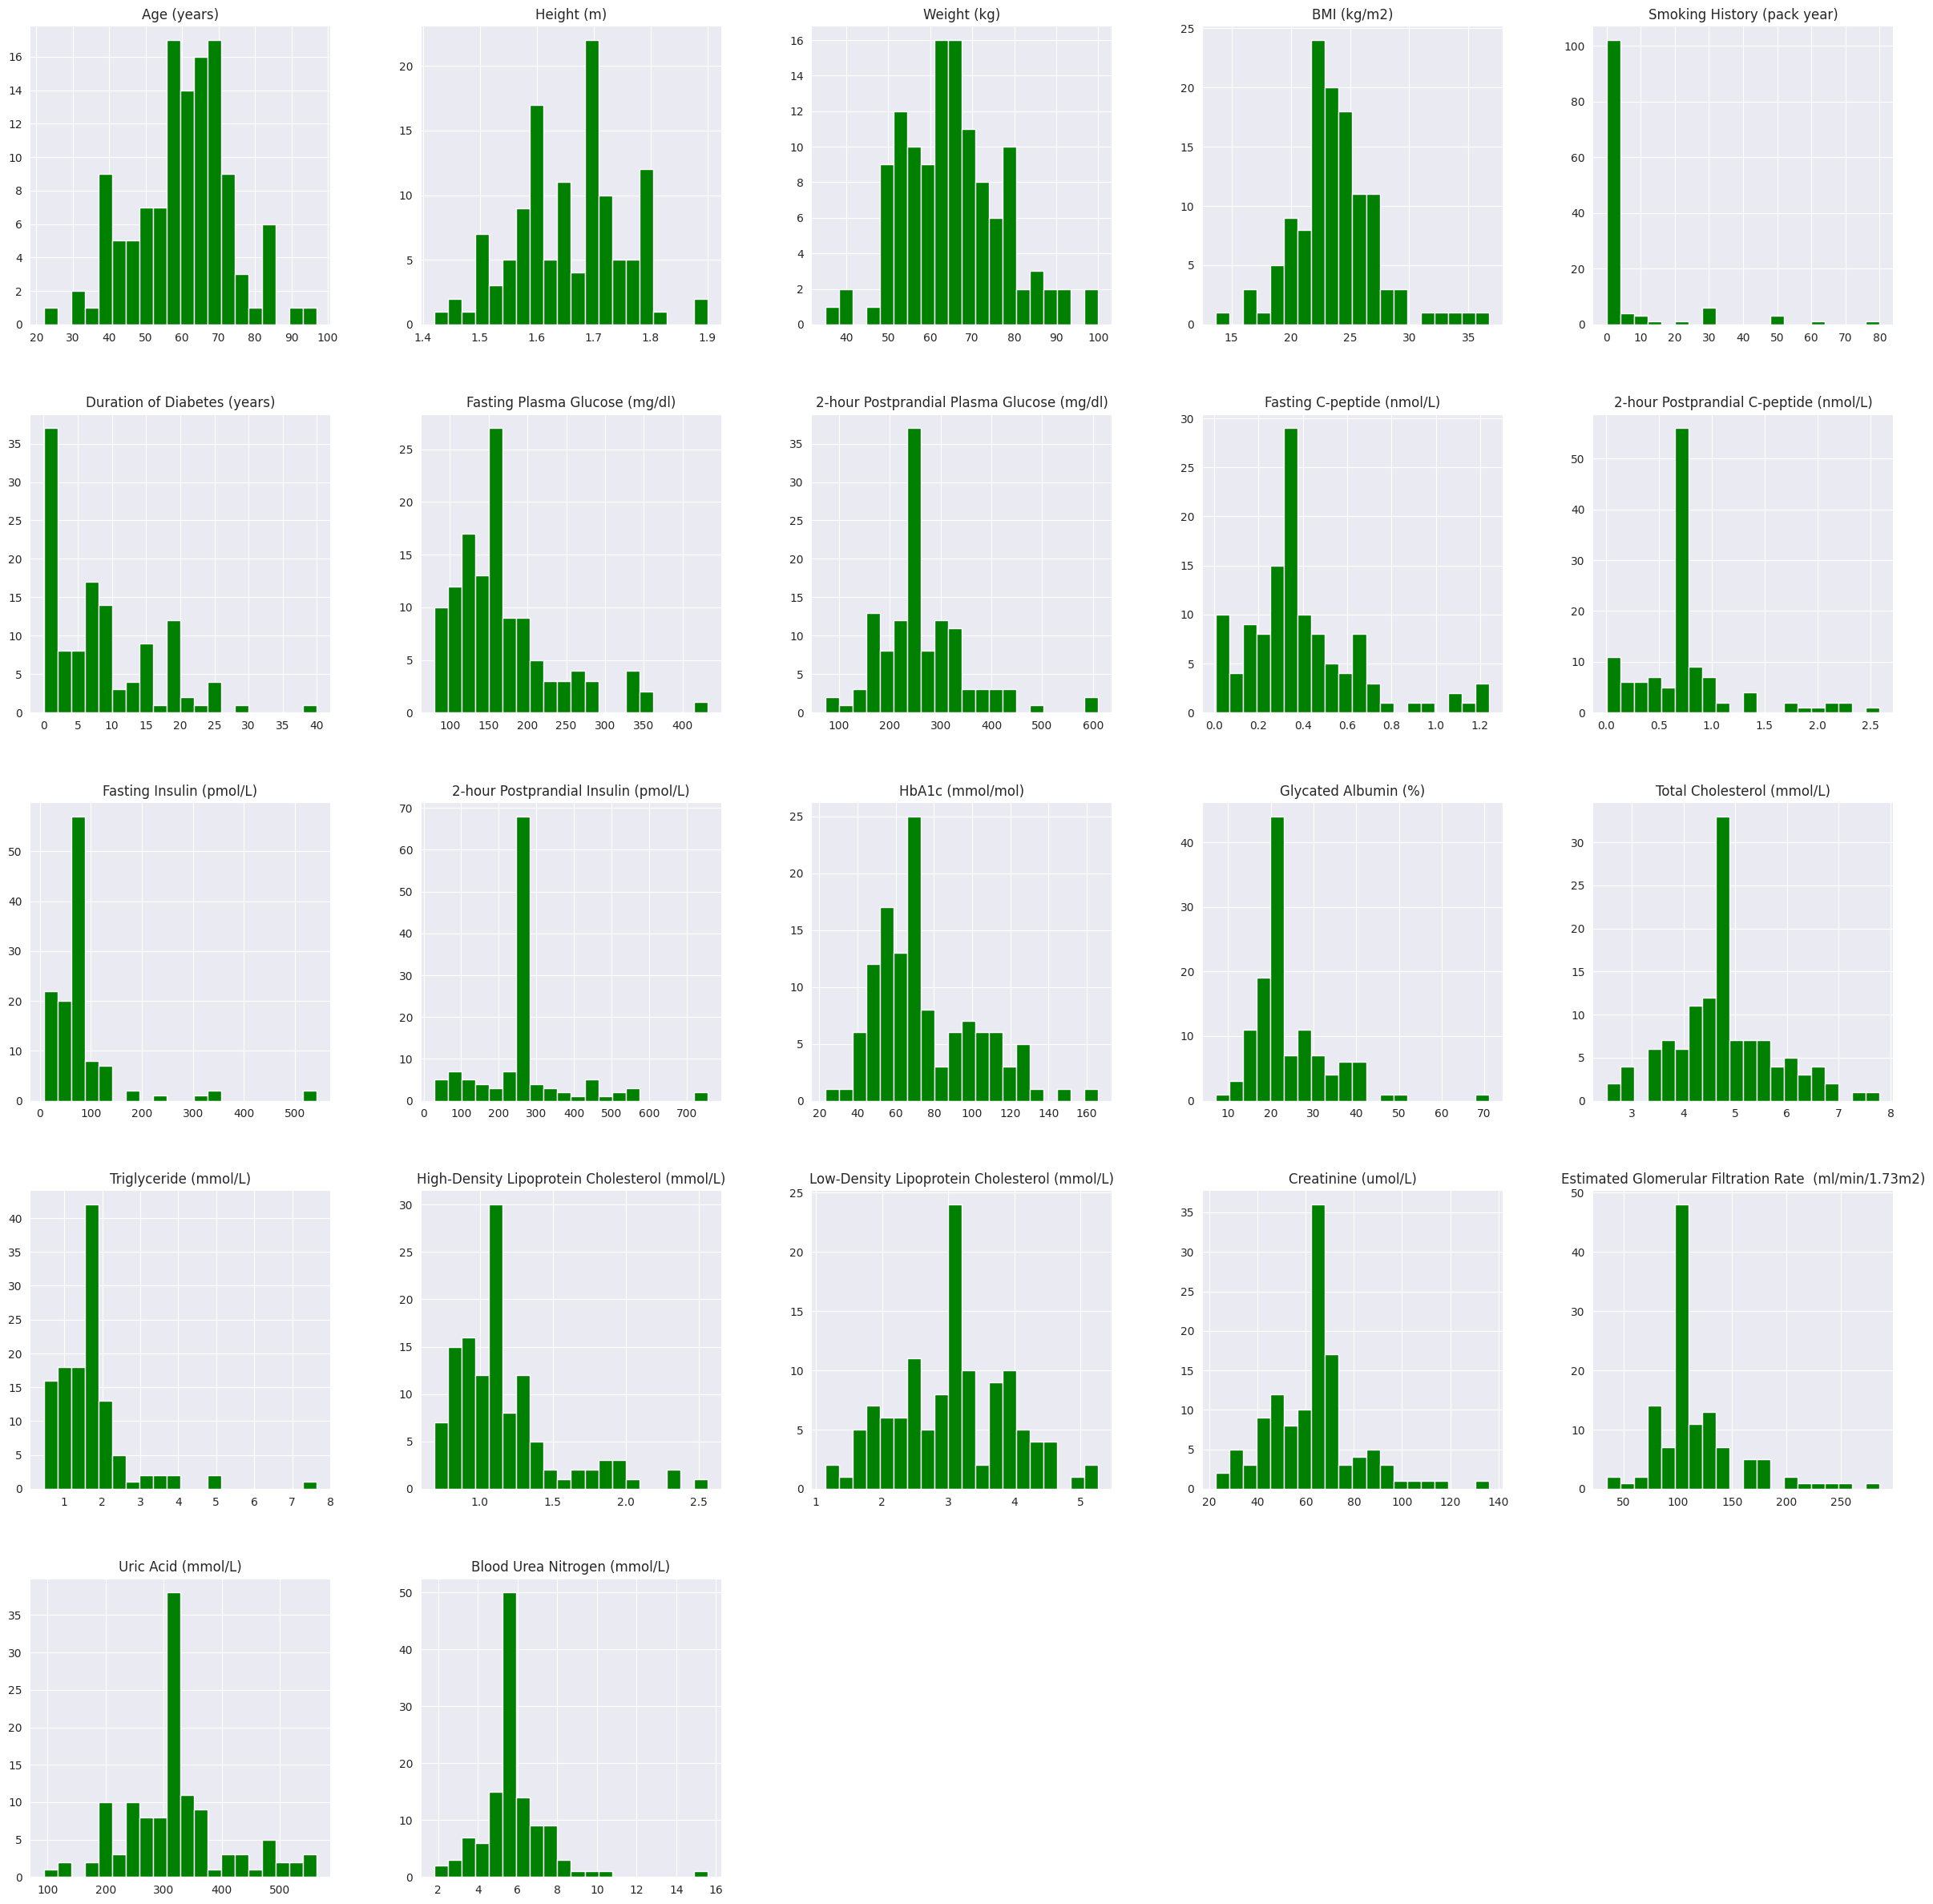

In [54]:
num_cols_to_fill = [
    'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
    'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)', '2-hour Postprandial Plasma Glucose (mg/dl)',
    'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
    '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)', 'Total Cholesterol (mmol/L)',
    'Triglyceride (mmol/L)', 'High-Density Lipoprotein Cholesterol (mmol/L)',
    'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
    'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)', 'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'
]
num_types_df = df[num_cols_to_fill]
num_types_df.hist(bins=20, figsize=(30, 30), color='green')

## Visualisation bin values

/tmp/ipykernel_1202502/1288852874.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')
/tmp/ipykernel_1202502/1288852874.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')
/tmp/ipykernel_1202502/1288852874.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')
/tmp/ipykernel_1202502/1288852874.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

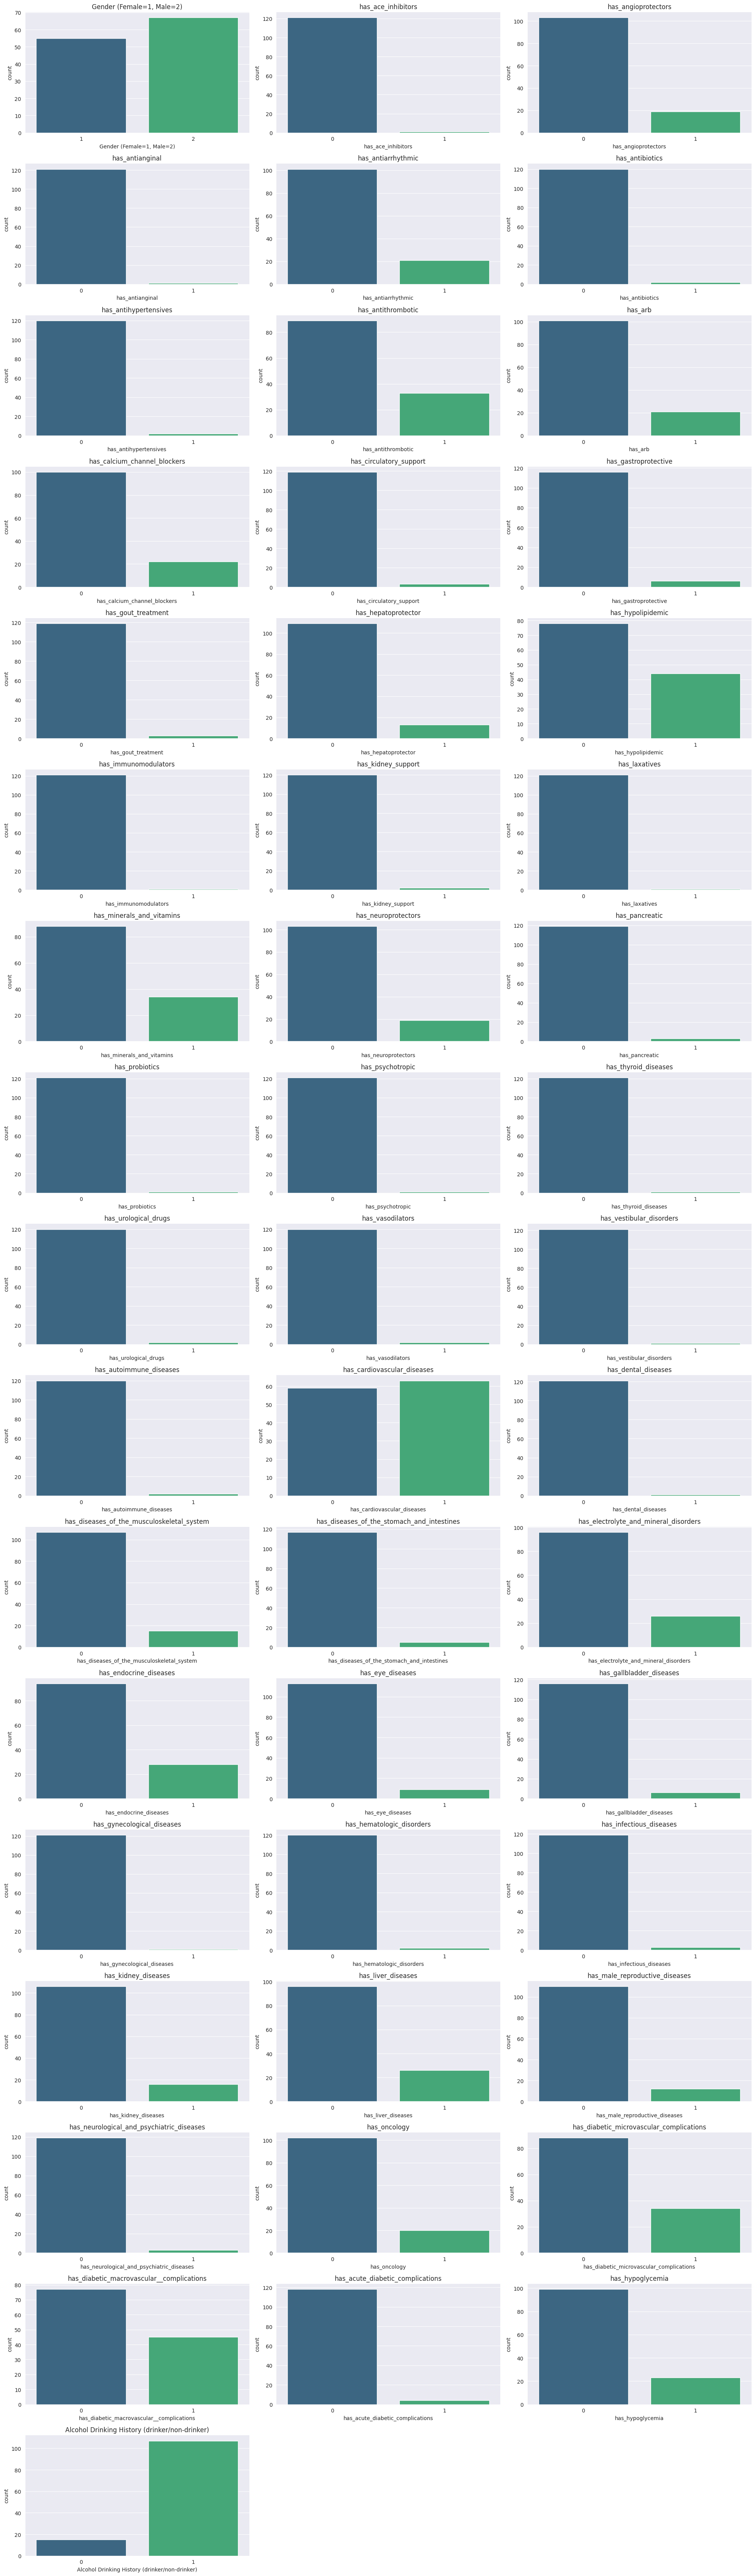

In [55]:
cat_cols_to_fill = [
    'Gender (Female=1, Male=2)', 'has_ace_inhibitors', 'has_angioprotectors', 'has_antianginal',
    'has_antiarrhythmic', 'has_antibiotics', 'has_antihypertensives', 'has_antithrombotic', 'has_arb',
    'has_calcium_channel_blockers', 'has_circulatory_support', 'has_gastroprotective', 'has_gout_treatment',
    'has_hepatoprotector', 'has_hypolipidemic', 'has_immunomodulators', 'has_kidney_support', 'has_laxatives',
    'has_minerals_and_vitamins', 'has_neuroprotectors', 'has_pancreatic', 'has_probiotics', 'has_psychotropic',
    'has_thyroid_diseases', 'has_urological_drugs', 'has_vasodilators', 'has_vestibular_disorders',
    'has_autoimmune_diseases', 'has_cardiovascular_diseases', 'has_dental_diseases',
    'has_diseases_of_the_musculoskeletal_system', 'has_diseases_of_the_stomach_and_intestines',
    'has_electrolyte_and_mineral_disorders', 'has_endocrine_diseases', 'has_eye_diseases', 'has_gallbladder_diseases',
    'has_gynecological_diseases', 'has_hematologic_disorders', 'has_infectious_diseases', 'has_kidney_diseases',
    'has_liver_diseases', 'has_male_reproductive_diseases', 'has_neurological_and_psychiatric_diseases', 'has_oncology',
    'has_diabetic_microvascular_complications', 'has_diabetic_macrovascular__complications',
    'has_acute_diabetic_complications', 'has_hypoglycemia', 'Alcohol Drinking History (drinker/non-drinker)'
]

cat_types_combined_df = combined_df[cat_cols_to_fill]

n_cols = 3
n_rows = (len(cat_cols_to_fill) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(cat_cols_to_fill):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(data=df, x=col, palette='viridis')
    plt.title(col)
    plt.xticks()

plt.tight_layout()
plt.show()

## Correlation Matrix

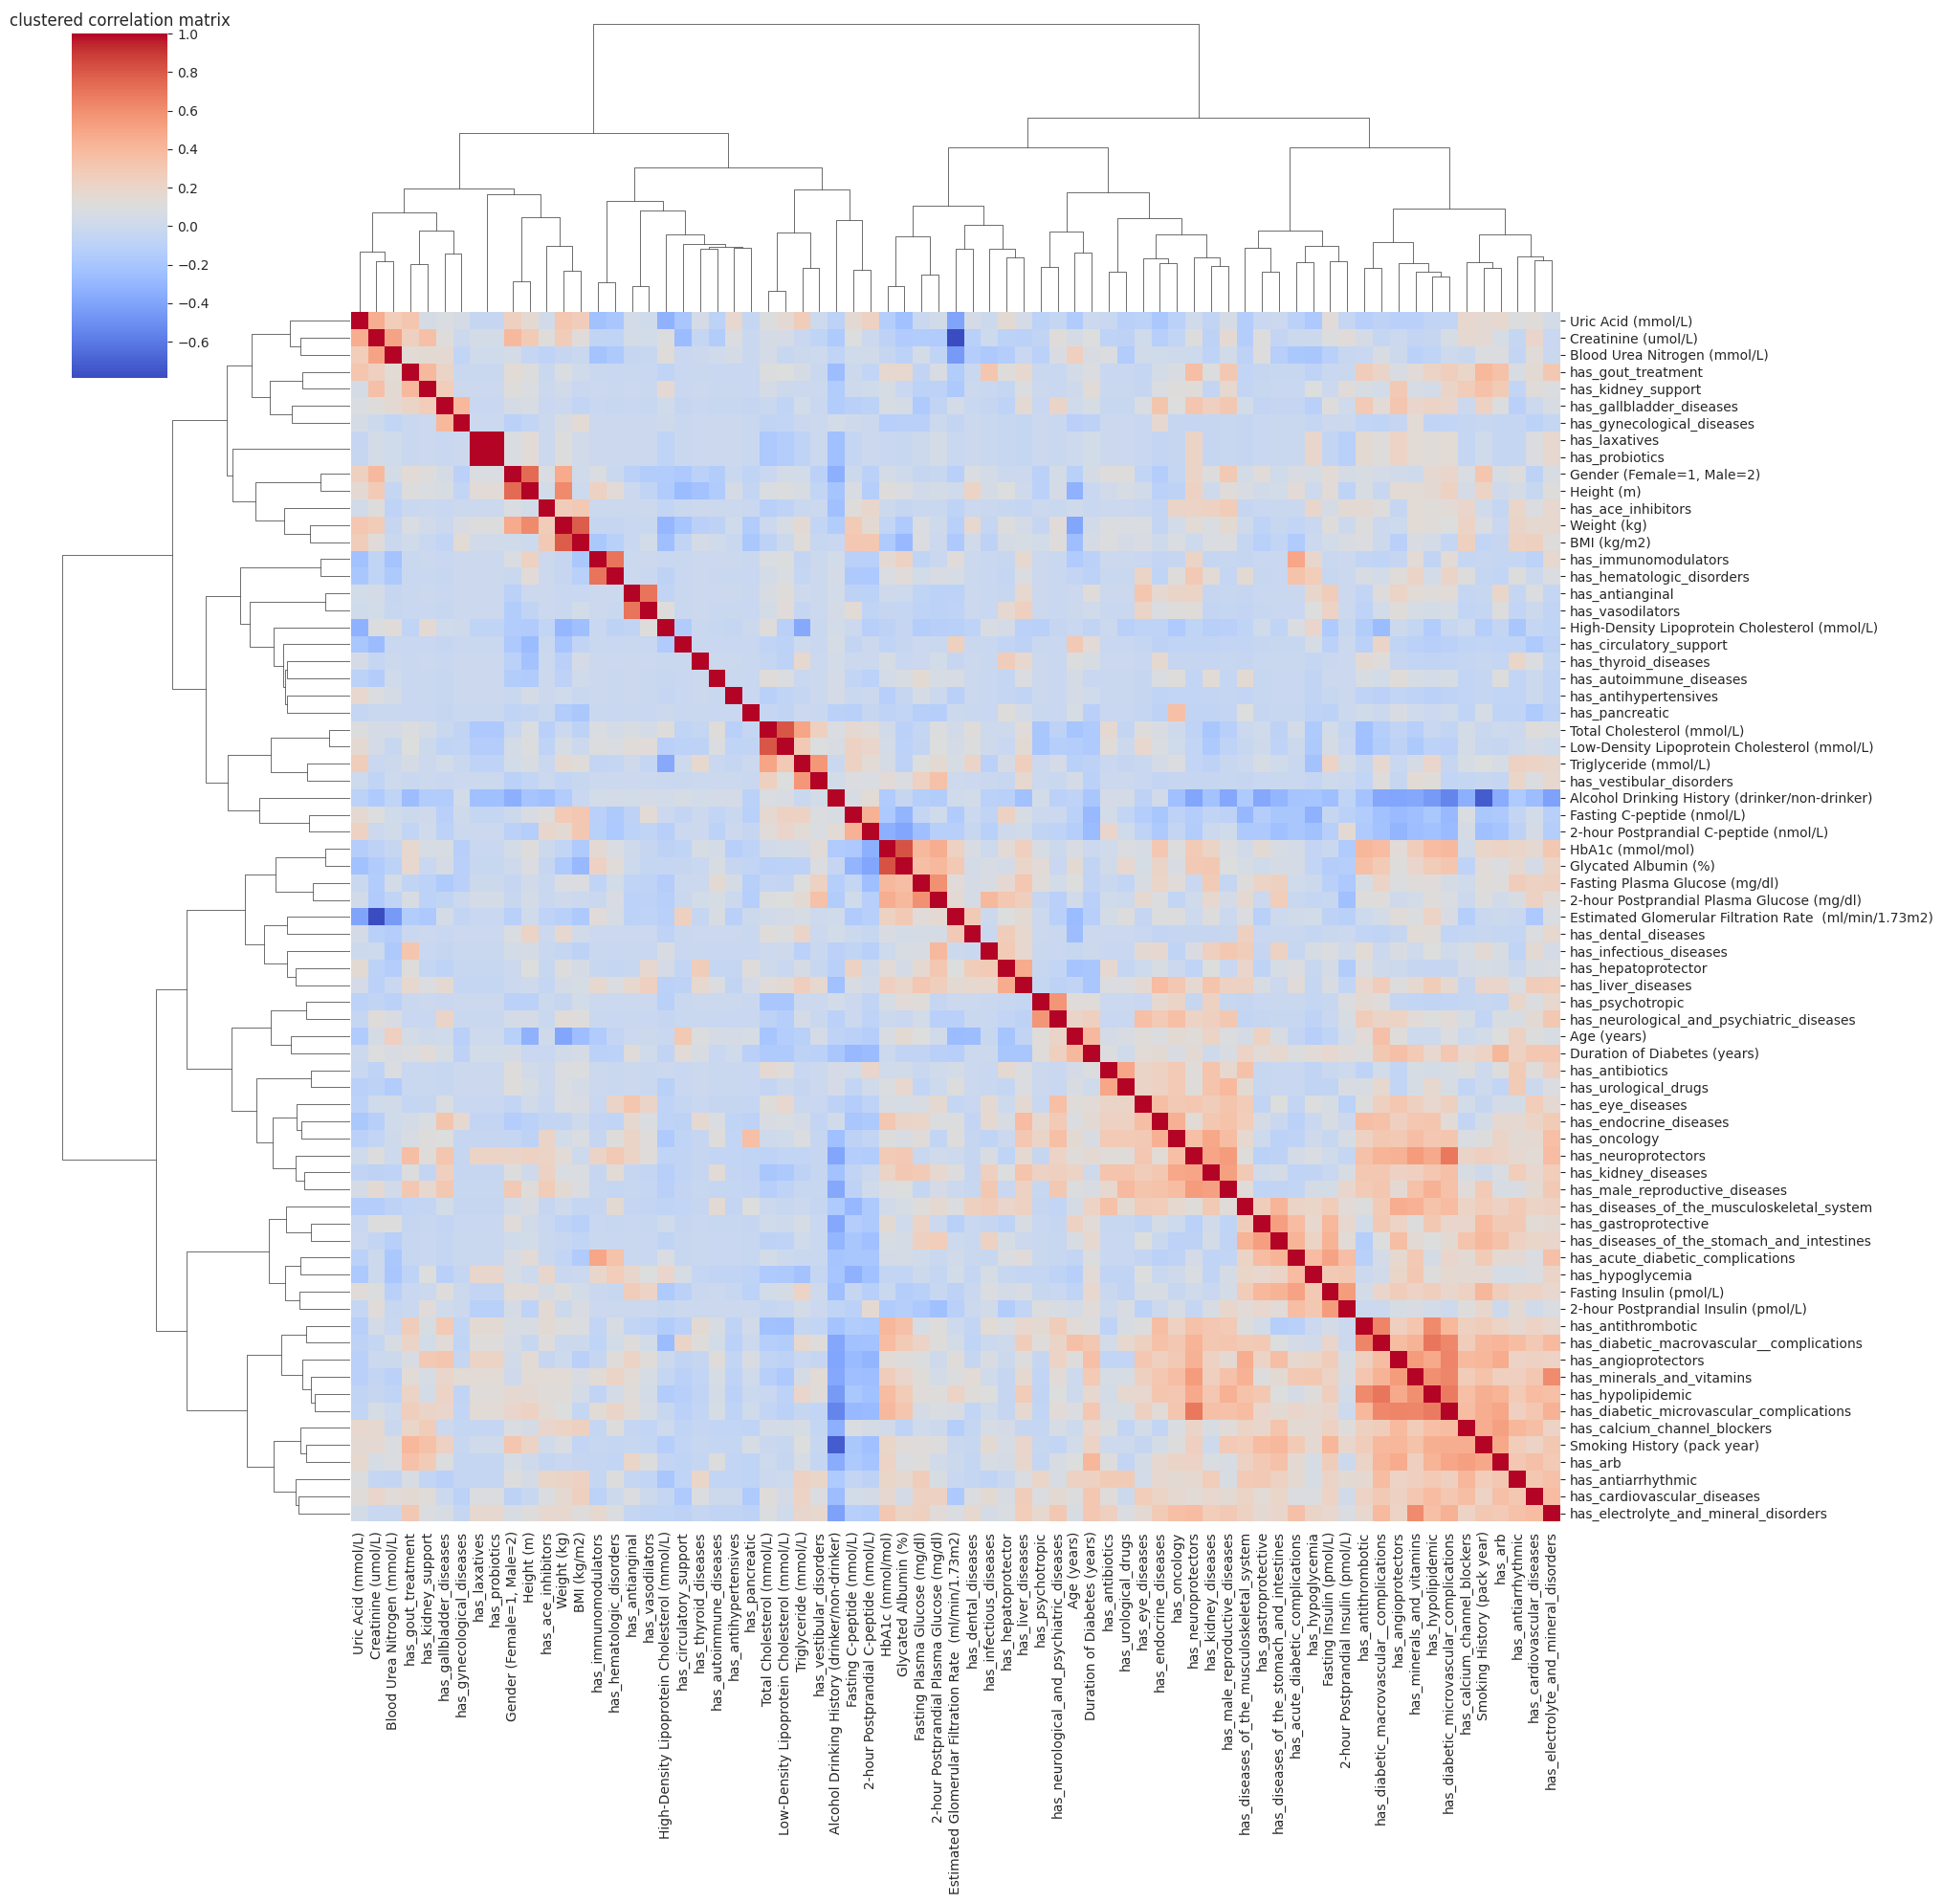

In [56]:
corr_matrix = df.corr(numeric_only=True)

sns.clustermap(corr_matrix,
               cmap='coolwarm',
               figsize=(20, 20),
               annot=False,
               method='ward')  #  (instead of 'ward' we can use 'average', 'single', 'complete')
plt.title("clustered correlation matrix")
plt.show()

# final dataset

In [137]:
folder_path = Path('../data/Shanghai_diabetes_datasets/2_step_finish_dataset/2_step_finish_dataset.csv')
df.to_csv(folder_path)

# PREDICTIVE ANALYSIS

# check if we have all variables

In [57]:
features = [
    'Gender (Female=1, Male=2)', 'has_ace_inhibitors', 'has_angioprotectors', 'has_antianginal',
    'has_antiarrhythmic', 'has_antibiotics', 'has_antihypertensives', 'has_antithrombotic', 'has_arb',
    'has_calcium_channel_blockers', 'has_circulatory_support', 'has_gastroprotective', 'has_gout_treatment',
    'has_hepatoprotector', 'has_hypolipidemic', 'has_immunomodulators', 'has_kidney_support', 'has_laxatives',
    'has_minerals_and_vitamins', 'has_neuroprotectors', 'has_pancreatic', 'has_probiotics', 'has_psychotropic',
    'has_thyroid_diseases', 'has_urological_drugs', 'has_vasodilators', 'has_vestibular_disorders',
    'has_autoimmune_diseases', 'has_cardiovascular_diseases', 'has_dental_diseases',
    'has_diseases_of_the_musculoskeletal_system', 'has_diseases_of_the_stomach_and_intestines',
    'has_electrolyte_and_mineral_disorders', 'has_endocrine_diseases', 'has_eye_diseases', 'has_gallbladder_diseases',
    'has_gynecological_diseases', 'has_hematologic_disorders', 'has_infectious_diseases', 'has_kidney_diseases',
    'has_liver_diseases', 'has_male_reproductive_diseases', 'has_neurological_and_psychiatric_diseases', 'has_oncology',
    'has_diabetic_microvascular_complications', 'has_diabetic_macrovascular__complications',
    'has_acute_diabetic_complications', 'has_hypoglycemia', 'Alcohol Drinking History (drinker/non-drinker)',
    'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
    'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)', '2-hour Postprandial Plasma Glucose (mg/dl)',
    'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
    '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)', 'Total Cholesterol (mmol/L)',
    'Triglyceride (mmol/L)', 'High-Density Lipoprotein Cholesterol (mmol/L)',
    'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
    'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)', 'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'
]


def have_all_variables(features, df):
    have = []
    not_have = []

    for feature in features:
        if feature in df.columns:
            have.append(feature)
        else:
            not_have.append(feature)

    print("have:", have)
    print("not have:", not_have)
    print(f"we found in df: {len(have)} don't have: {len(not_have)}")


have_all_variables(features, df)

have: ['Gender (Female=1, Male=2)', 'has_ace_inhibitors', 'has_angioprotectors', 'has_antianginal', 'has_antiarrhythmic', 'has_antibiotics', 'has_antihypertensives', 'has_antithrombotic', 'has_arb', 'has_calcium_channel_blockers', 'has_circulatory_support', 'has_gastroprotective', 'has_gout_treatment', 'has_hepatoprotector', 'has_hypolipidemic', 'has_immunomodulators', 'has_kidney_support', 'has_laxatives', 'has_minerals_and_vitamins', 'has_neuroprotectors', 'has_pancreatic', 'has_probiotics', 'has_psychotropic', 'has_thyroid_diseases', 'has_urological_drugs', 'has_vasodilators', 'has_vestibular_disorders', 'has_autoimmune_diseases', 'has_cardiovascular_diseases', 'has_dental_diseases', 'has_diseases_of_the_musculoskeletal_system', 'has_diseases_of_the_stomach_and_intestines', 'has_electrolyte_and_mineral_disorders', 'has_endocrine_diseases', 'has_eye_diseases', 'has_gallbladder_diseases', 'has_gynecological_diseases', 'has_hematologic_disorders', 'has_infectious_diseases', 'has_kidney

# vis-on 'Type of Diabetes' data

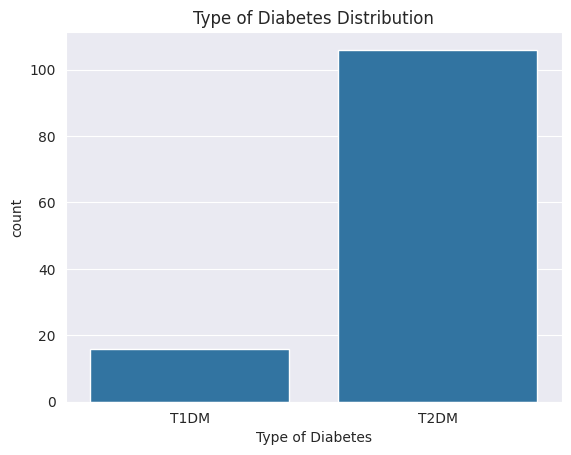

In [58]:
sns.countplot(x='Type of Diabetes', data=df)
plt.title('Type of Diabetes Distribution')
plt.show()

In [59]:
# over = SMOTE(sampling_strategy=0.2)
# under = RandomUnderSampler(sampling_strategy=0.6)

# Define preprocessor

In [60]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),
         ['Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
          'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
          '2-hour Postprandial Plasma Glucose (mg/dl)',
          'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
          '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
          'Total Cholesterol (mmol/L)',
          'Triglyceride (mmol/L)', 'High-Density Lipoprotein Cholesterol (mmol/L)',
          'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
          'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)', 'Uric Acid (mmol/L)',
          'Blood Urea Nitrogen (mmol/L)']),
        ('bin', 'passthrough', [
            'Gender (Female=1, Male=2)', 'has_ace_inhibitors', 'has_angioprotectors', 'has_antianginal',
            'has_antiarrhythmic', 'has_antibiotics', 'has_antihypertensives', 'has_antithrombotic', 'has_arb',
            'has_calcium_channel_blockers', 'has_circulatory_support', 'has_gastroprotective', 'has_gout_treatment',
            'has_hepatoprotector', 'has_hypolipidemic', 'has_immunomodulators', 'has_kidney_support', 'has_laxatives',
            'has_minerals_and_vitamins', 'has_neuroprotectors', 'has_pancreatic', 'has_probiotics', 'has_psychotropic',
            'has_thyroid_diseases', 'has_urological_drugs', 'has_vasodilators', 'has_vestibular_disorders',
            'has_autoimmune_diseases', 'has_cardiovascular_diseases', 'has_dental_diseases',
            'has_diseases_of_the_musculoskeletal_system', 'has_diseases_of_the_stomach_and_intestines',
            'has_electrolyte_and_mineral_disorders', 'has_endocrine_diseases', 'has_eye_diseases',
            'has_gallbladder_diseases',
            'has_gynecological_diseases', 'has_hematologic_disorders', 'has_infectious_diseases', 'has_kidney_diseases',
            'has_liver_diseases', 'has_male_reproductive_diseases', 'has_neurological_and_psychiatric_diseases',
            'has_oncology',
            'has_diabetic_microvascular_complications', 'has_diabetic_macrovascular__complications',
            'has_acute_diabetic_complications', 'has_hypoglycemia', 'Alcohol Drinking History (drinker/non-drinker)'
        ])
    ]
)

X = df.drop('Type of Diabetes', axis=1)
y = df['Type of Diabetes']

### Check data after Smote and RandomUnderSampler

In [61]:
df.shape

(122, 73)

In [62]:
pipeline_check = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.2, random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=42))
])

X_resampled, y_resampled = pipeline_check.fit_resample(X, y)

print('new class distribution: ', Counter(y_resampled))

new class distribution:  Counter({'T2DM': 42, 'T1DM': 21})


### Visual-on types of diabetes

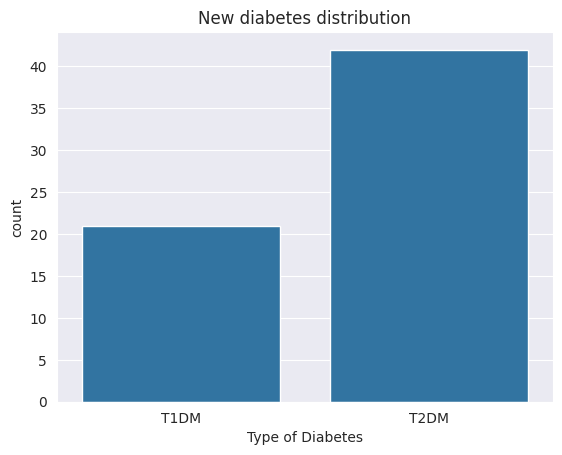

In [63]:
data_check = pd.DataFrame(y_resampled)

sns.countplot(data=data_check, x='Type of Diabetes')
plt.title('New diabetes distribution')
plt.show()

# Create Pipeline / predict and evaluate

## RFC

In [64]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [65]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [66]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

grid_search.fit(X_train, y_train)

print('best parameters: ', grid_search.best_params_)

best parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}


In [67]:
y_pred = grid_search.predict(X_test)

print('model accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy:  0.96
              precision    recall  f1-score   support

        T1DM       1.00      0.75      0.86         4
        T2DM       0.95      1.00      0.98        21

    accuracy                           0.96        25
   macro avg       0.98      0.88      0.92        25
weighted avg       0.96      0.96      0.96        25



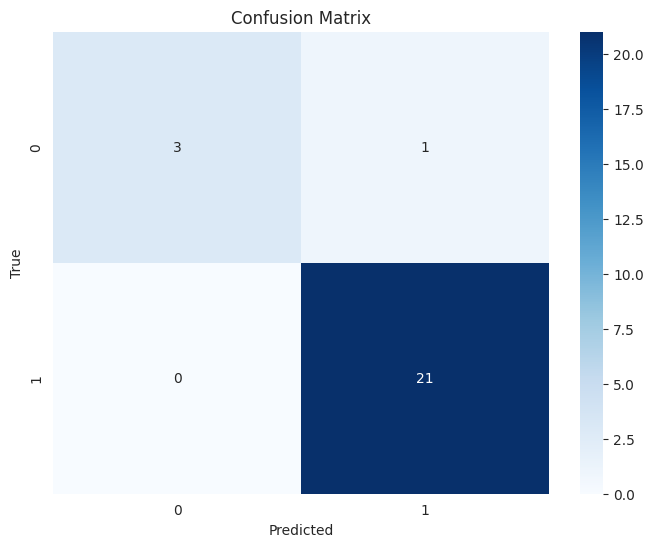

In [68]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### DTC

In [69]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [70]:
param_grid = {
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_depth': [10, 20, 30],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_leaf_nodes': [10, 20, 50],
}

In [71]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

best parameters {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__max_leaf_nodes': 20, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5}


In [72]:
y_pred = grid_search.predict(X_test)
print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.8
              precision    recall  f1-score   support

        T1DM       0.40      0.50      0.44         4
        T2DM       0.90      0.86      0.88        21

    accuracy                           0.80        25
   macro avg       0.65      0.68      0.66        25
weighted avg       0.82      0.80      0.81        25



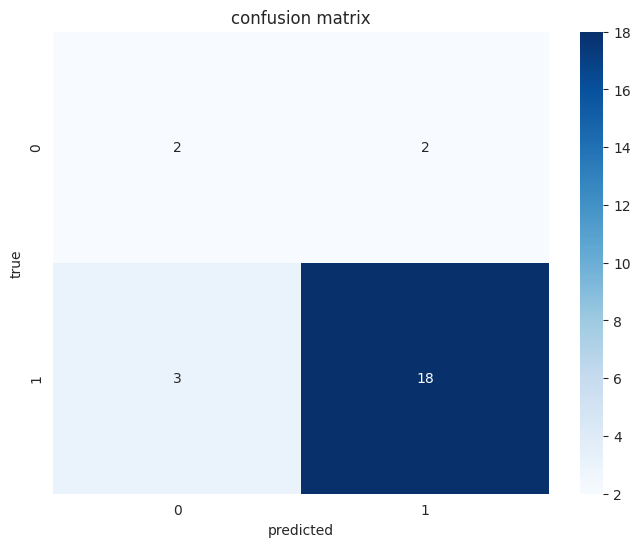

In [73]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

## KNN

In [74]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]
)

In [75]:
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': [1, 2],
    'classifier__weights': ['uniform', 'distance'],
}

In [76]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

best parameters {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'distance'}


In [77]:
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.84
              precision    recall  f1-score   support

        T1DM       0.00      0.00      0.00         4
        T2DM       0.84      1.00      0.91        21

    accuracy                           0.84        25
   macro avg       0.42      0.50      0.46        25
weighted avg       0.71      0.84      0.77        25



/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no

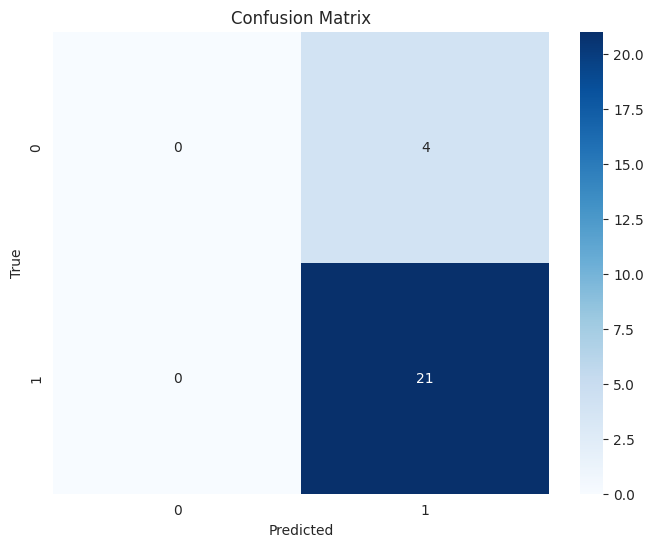

In [78]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## LR

In [79]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ]
)

In [80]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [300, 500, 1000]
}

In [81]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print('best parameters', grid_search.best_params_)

/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenv

best parameters {'classifier__C': 1, 'classifier__max_iter': 300, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [82]:
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.92
              precision    recall  f1-score   support

        T1DM       1.00      0.50      0.67         4
        T2DM       0.91      1.00      0.95        21

    accuracy                           0.92        25
   macro avg       0.96      0.75      0.81        25
weighted avg       0.93      0.92      0.91        25



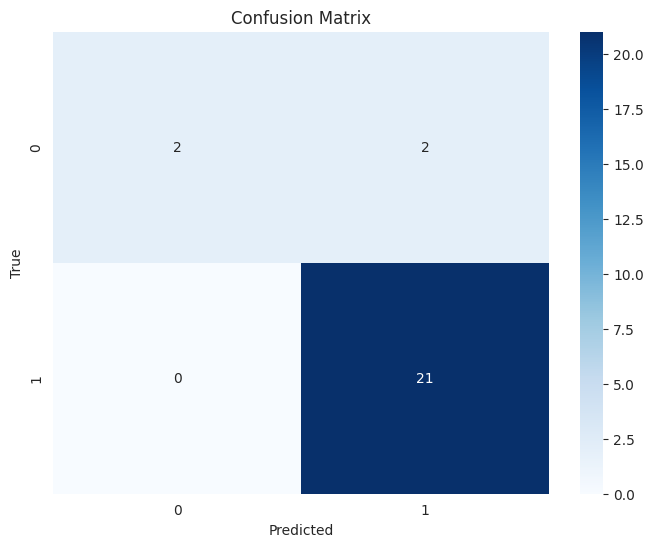

In [83]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [84]:
print(sorted(y.unique()))
# 'T1DM' - 0, 'T2DM' - 1

['T1DM', 'T2DM']


## XGBoost

In [125]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier())
    ]
)

In [126]:
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [100, 200],
    'classifier__subsample': [0.8, 1.0],
}

In [127]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=5)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

best parameters {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


In [128]:
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.96
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.95      1.00      0.98        21

    accuracy                           0.96        25
   macro avg       0.98      0.88      0.92        25
weighted avg       0.96      0.96      0.96        25



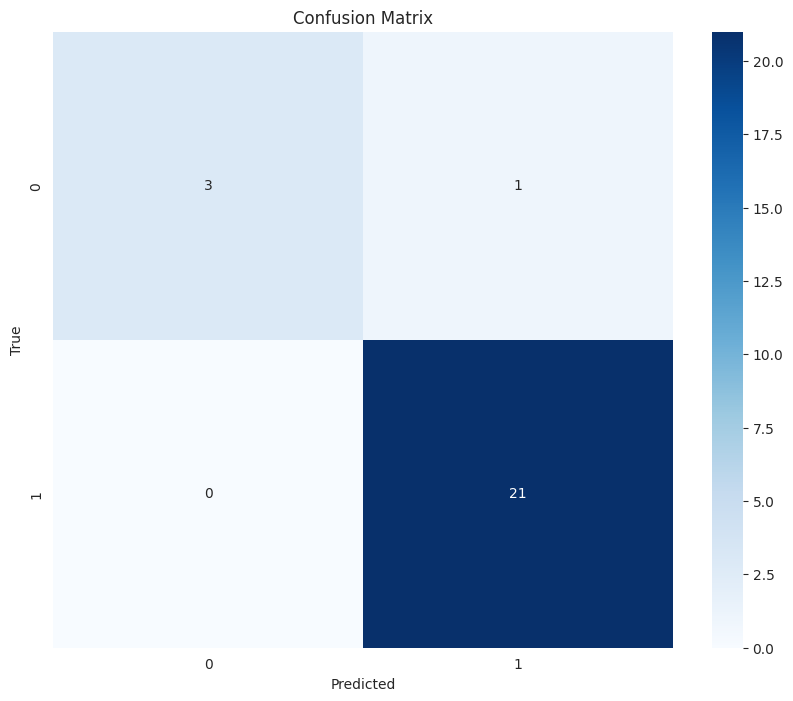

In [129]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Lightgbm

In [132]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(verbose=-1))
    ]
)

In [133]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__num_leaves': [15, 31],
    'classifier__min_child_samples': [10, 20, 30],
}

In [134]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature

best parameters {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_samples': 20, 'classifier__n_estimators': 100, 'classifier__num_leaves': 15}


/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [135]:
y_pred = grid_search.predict(X_test)

print('model accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy:  0.96
              precision    recall  f1-score   support

        T1DM       1.00      0.75      0.86         4
        T2DM       0.95      1.00      0.98        21

    accuracy                           0.96        25
   macro avg       0.98      0.88      0.92        25
weighted avg       0.96      0.96      0.96        25



/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


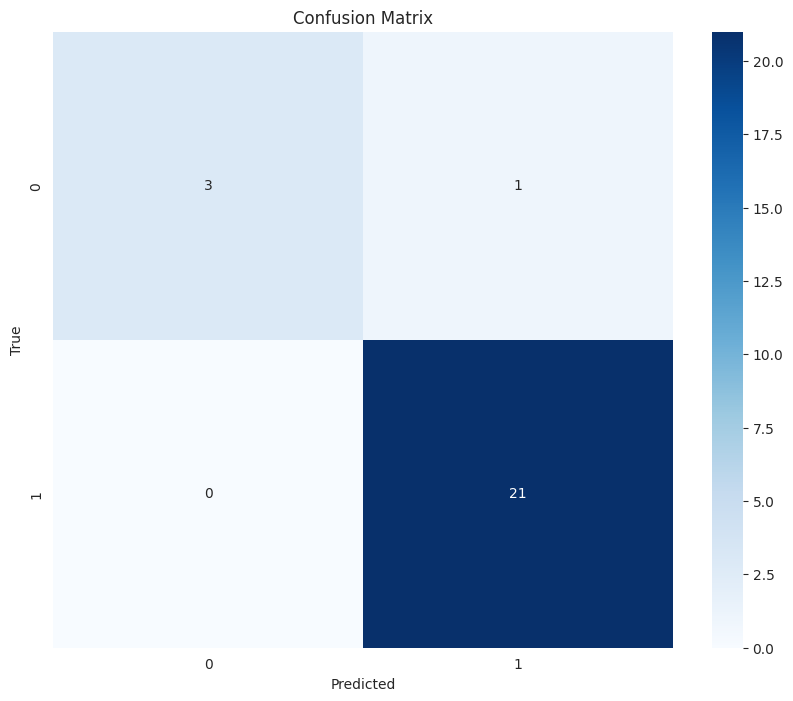

In [136]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()